In [1]:
#!jupyter nbconvert --to html /content/drive/MyDrive/Colab_Notebooks/MAE_598_Design_Optimization.ipynb

In [2]:
#!sudo apt-get install texlive-xetex texlive-fonts-recommended texlive-plain-generic
#!jupyter nbconvert --to pdf /content/drive/MyDrive/Colab_Notebooks/MAE_598_Design_Optimization.ipynb

In [3]:
!pip install jupyterthemes

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 28.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.7/46.7 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 62.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 5.6 MB/s eta 0:00:00


In [4]:
import logging
import math
import random
import numpy as np
import time
import torch
import torch.nn as nn
from torch import optim
from torch.nn import utils
import matplotlib.pyplot as plt
from ipywidgets import IntProgress
from IPython.display import display
from matplotlib import pyplot as plt, rc
import matplotlib.patches as patches
from matplotlib.animation import FuncAnimation, PillowWriter
from jupyterthemes import jtplot

In [5]:
# environment parameters
frame_time = 0.2 #time interval(seconds)
lr = 1 # Length of rear axle to the center(meters)
lf = 1 # Length of front axle to the center(meters)



[1] loss: 169.661


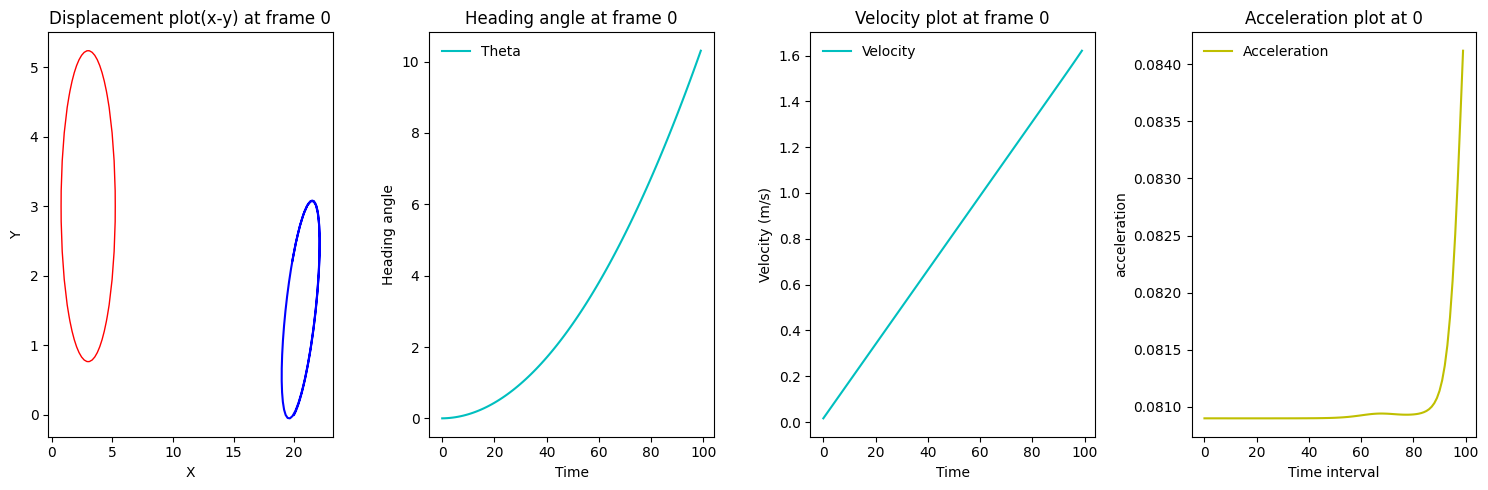

[2] loss: 167.962


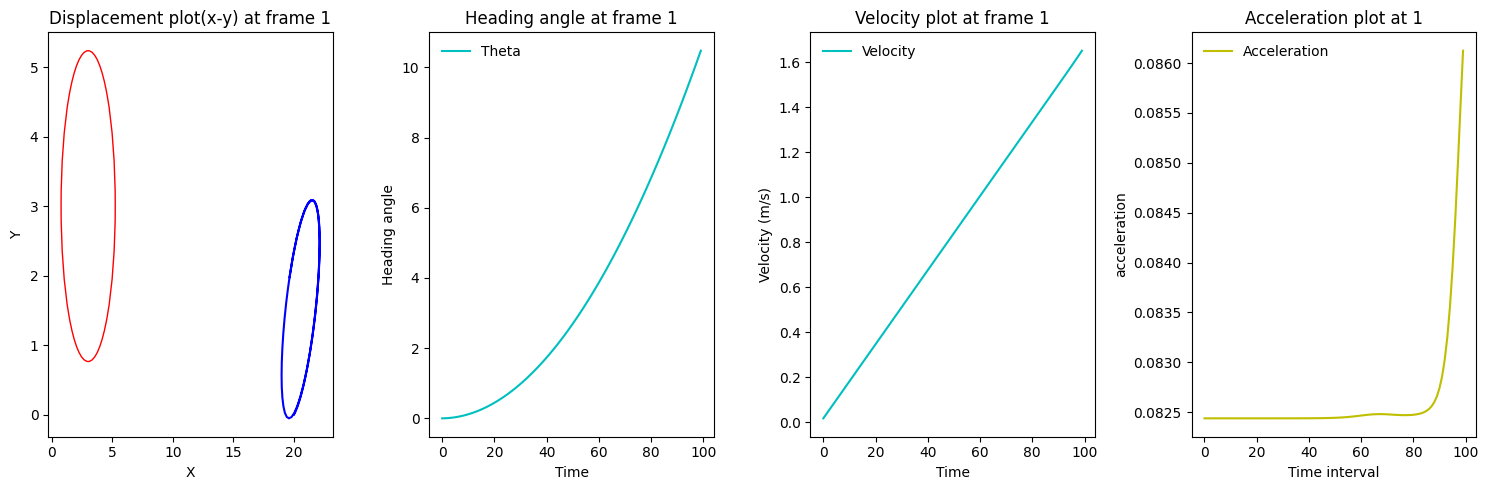

[3] loss: 166.910


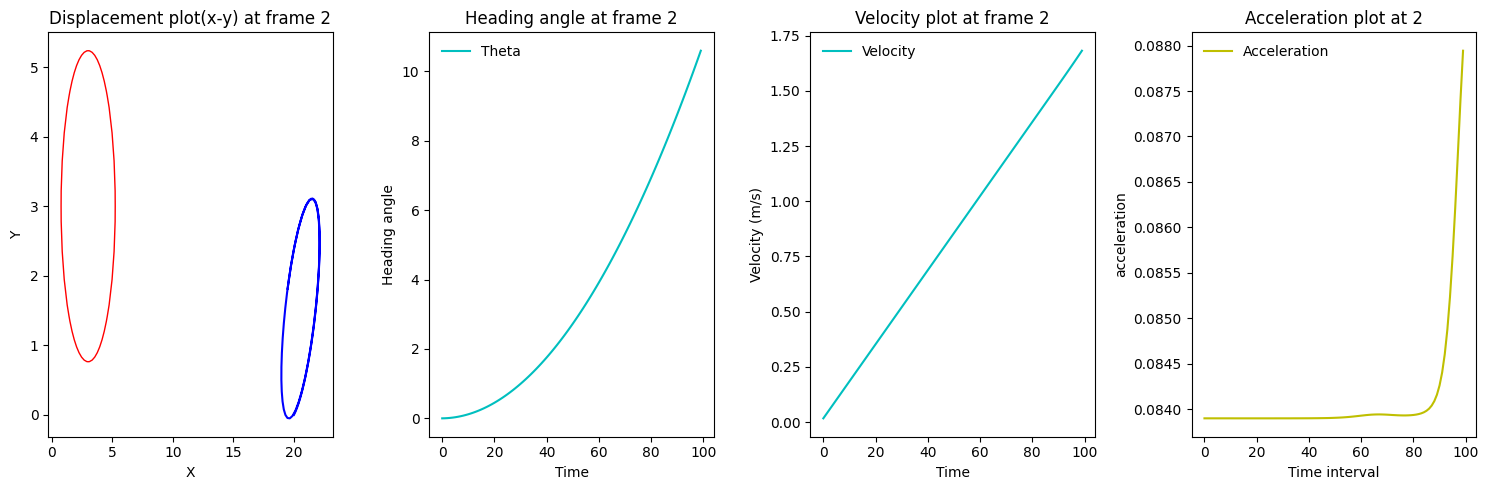

[4] loss: 166.138


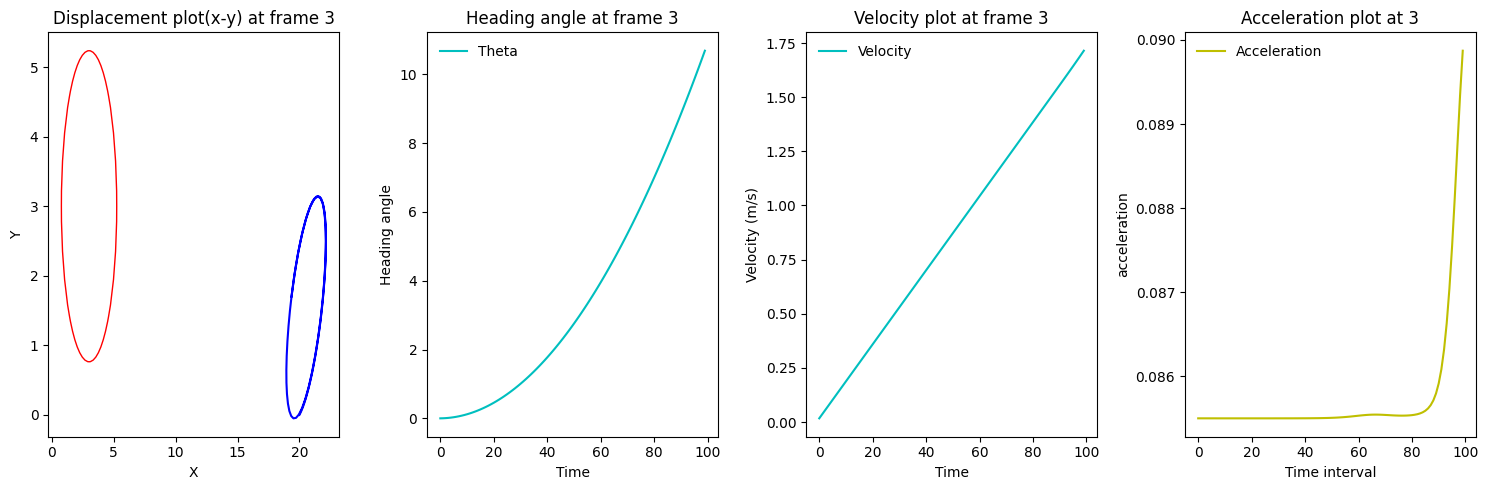

[5] loss: 165.468


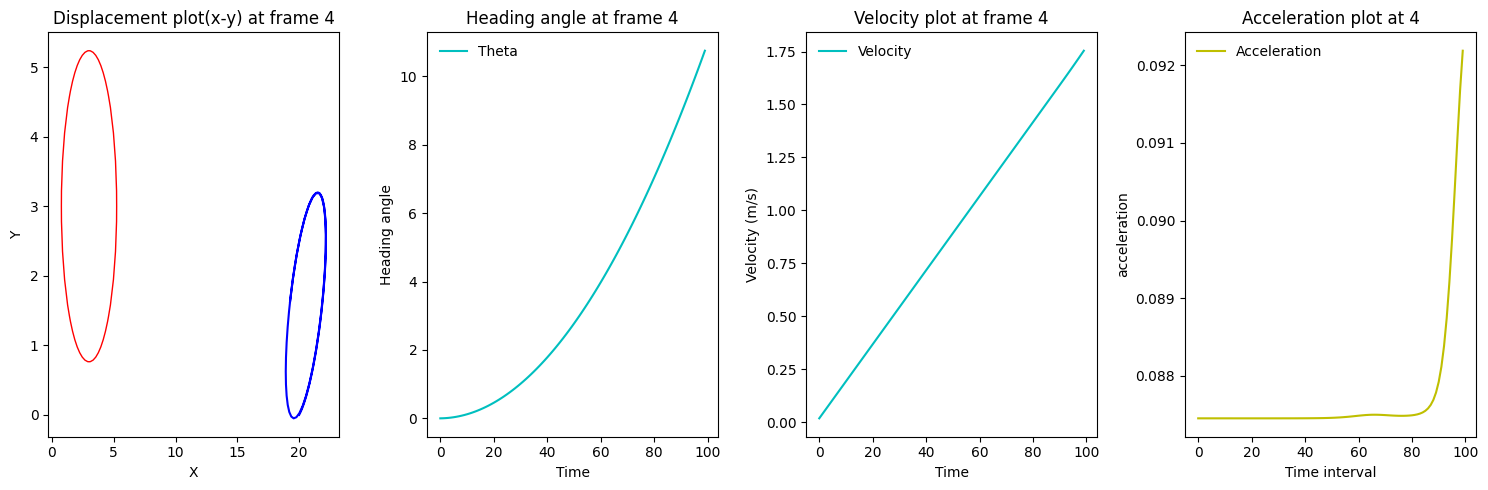

[6] loss: 164.677


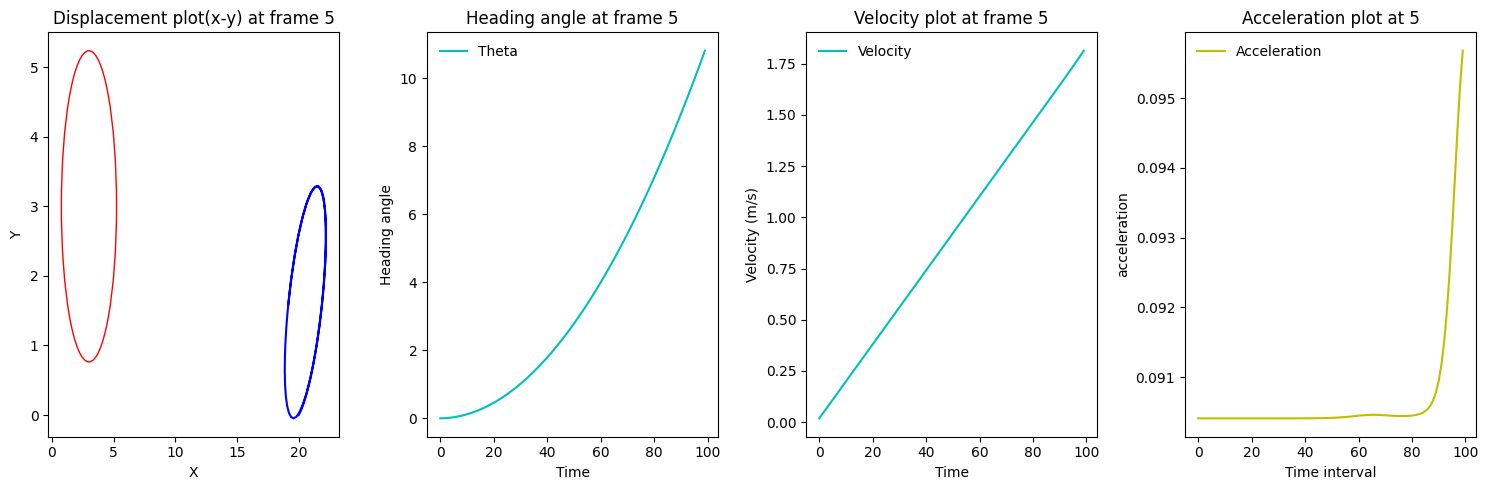

[7] loss: 162.733


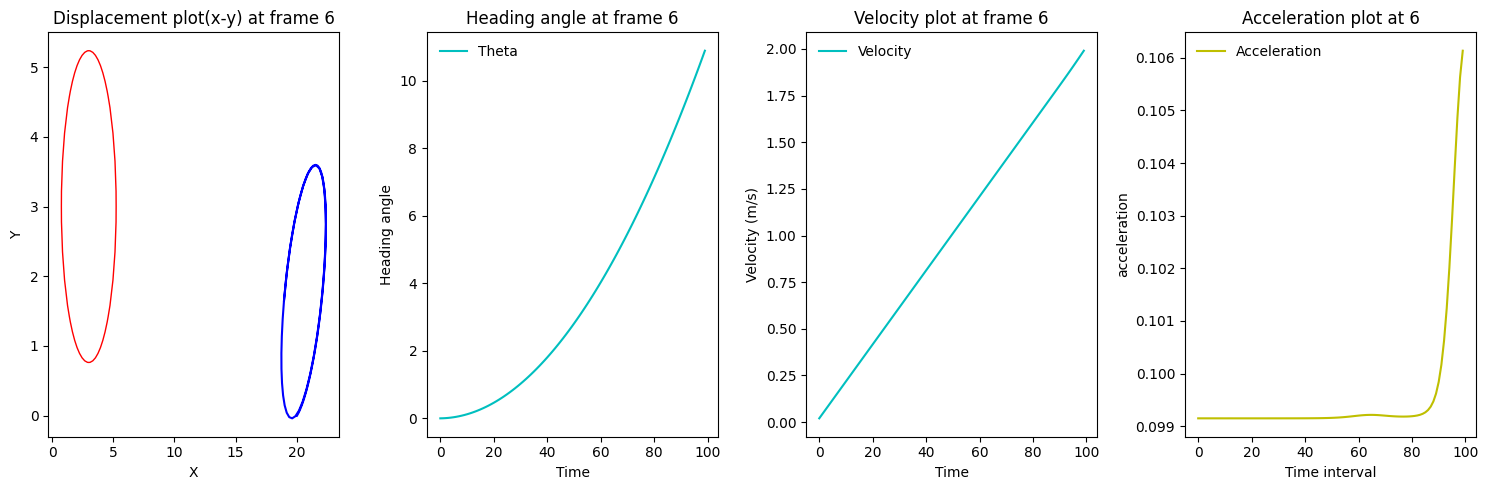

[8] loss: 153.369


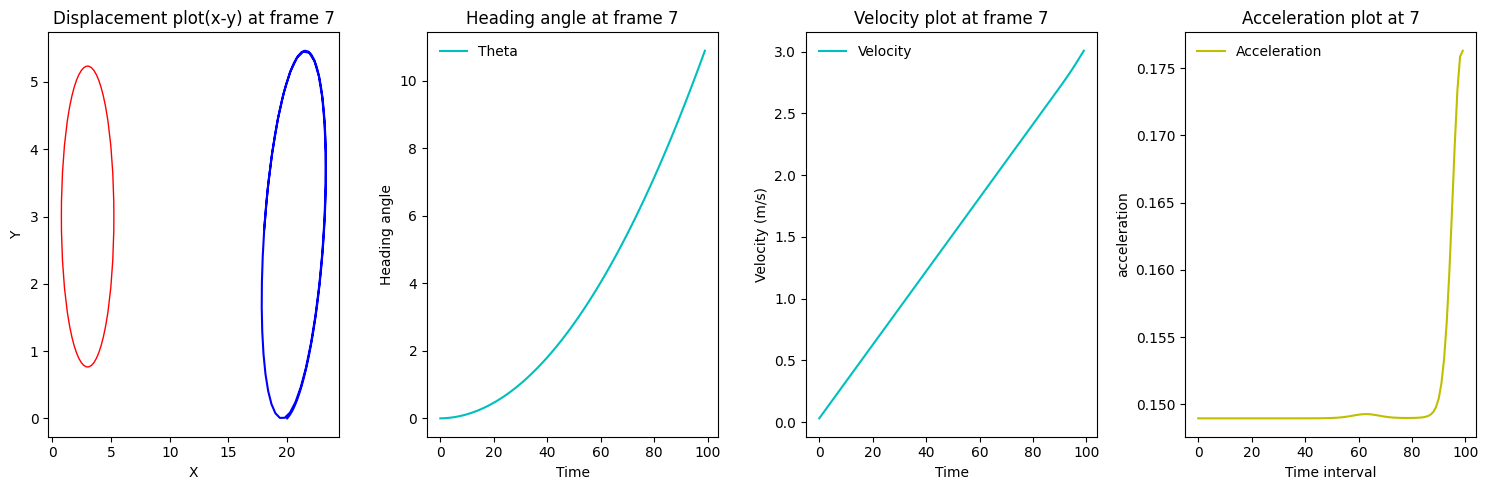

[9] loss: 143.342


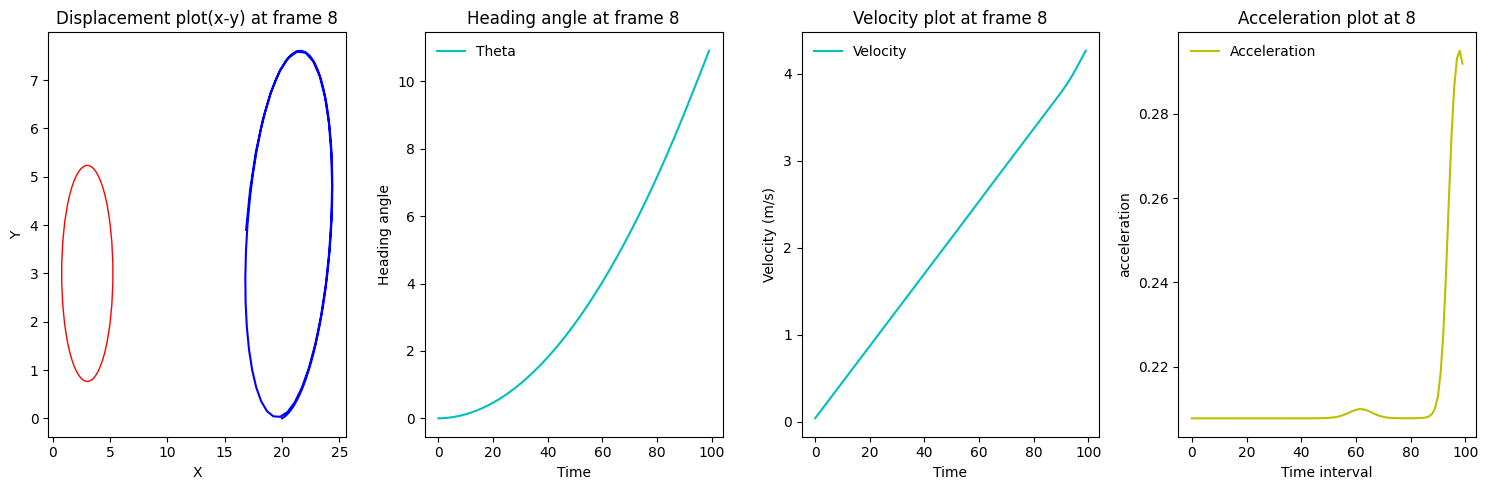

[10] loss: 136.568


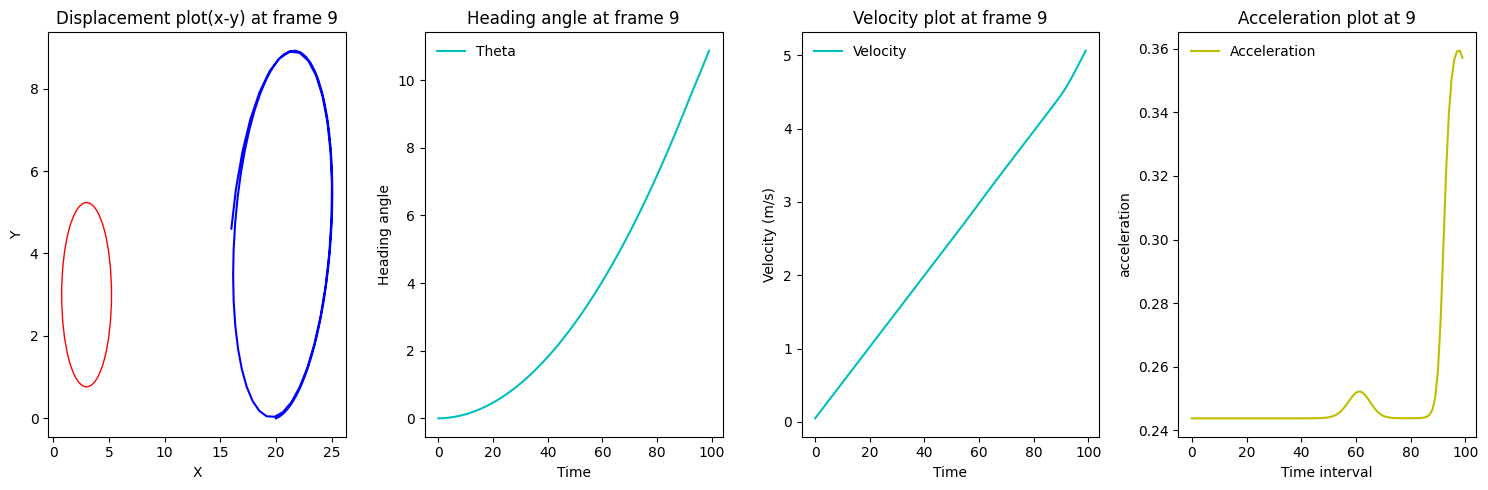

[11] loss: 124.075


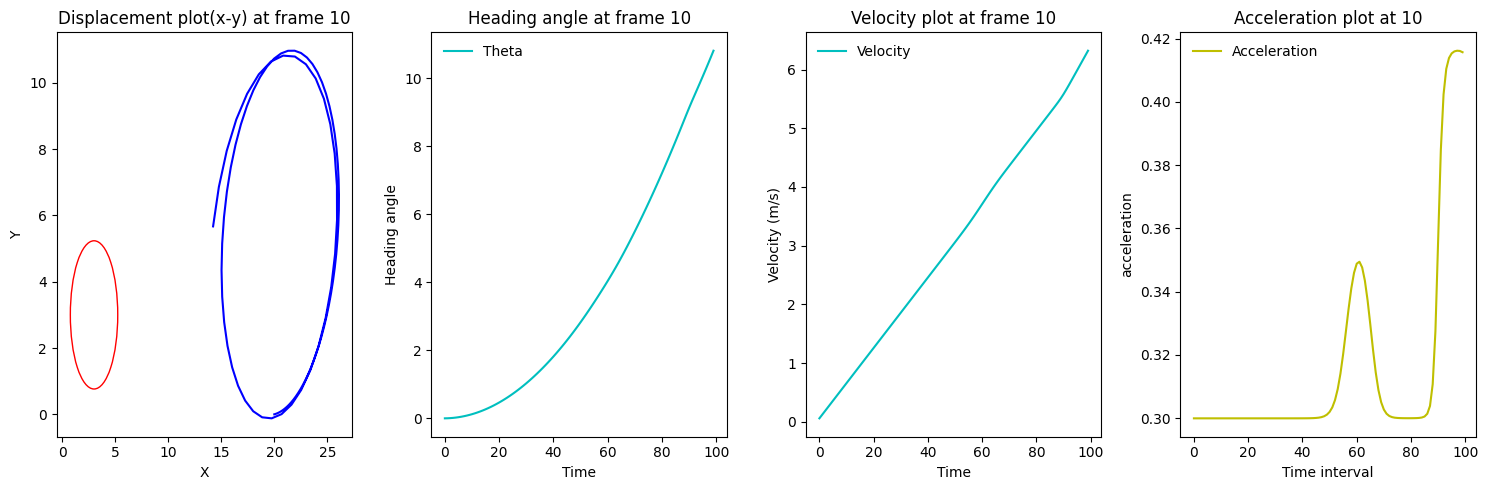

[12] loss: 111.589


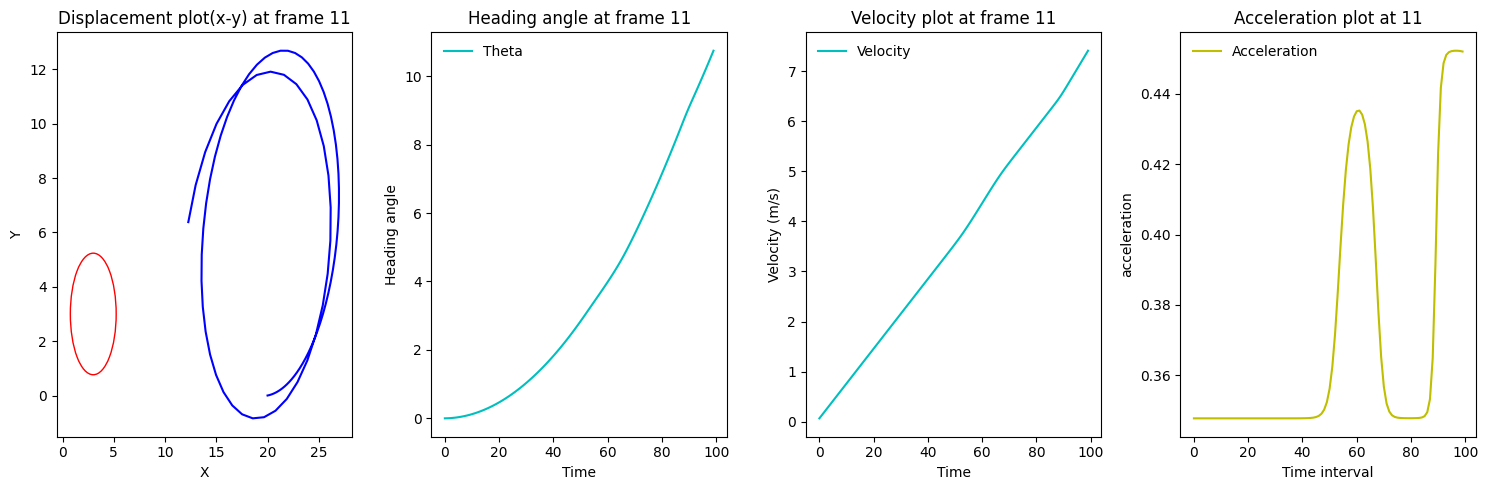

[13] loss: 84.409


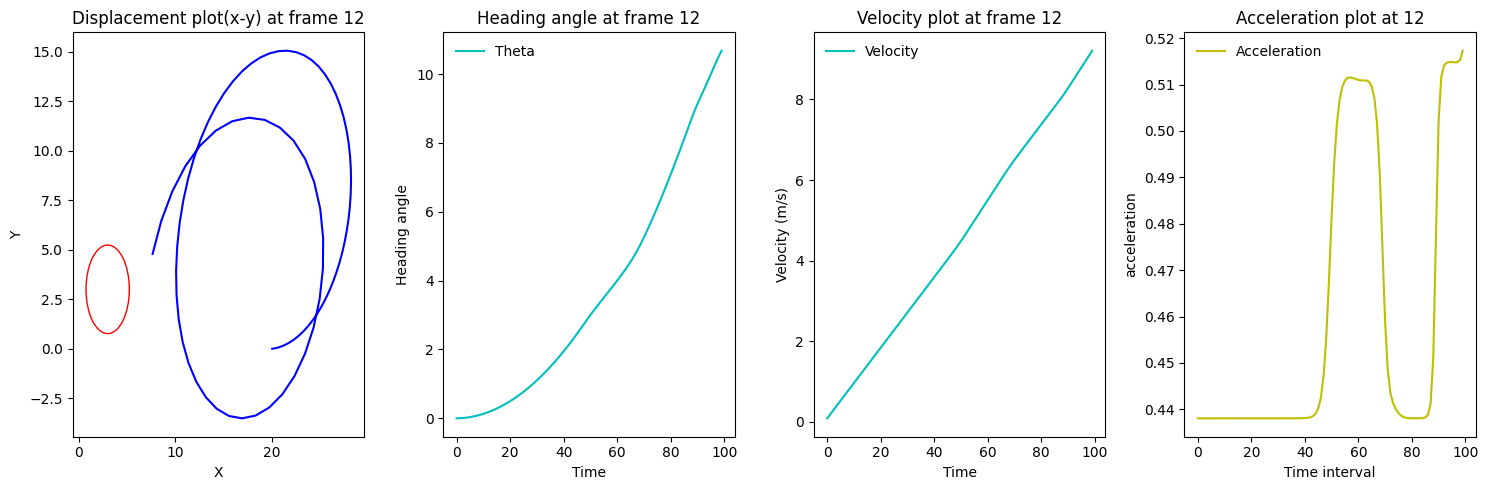

[14] loss: 78.998


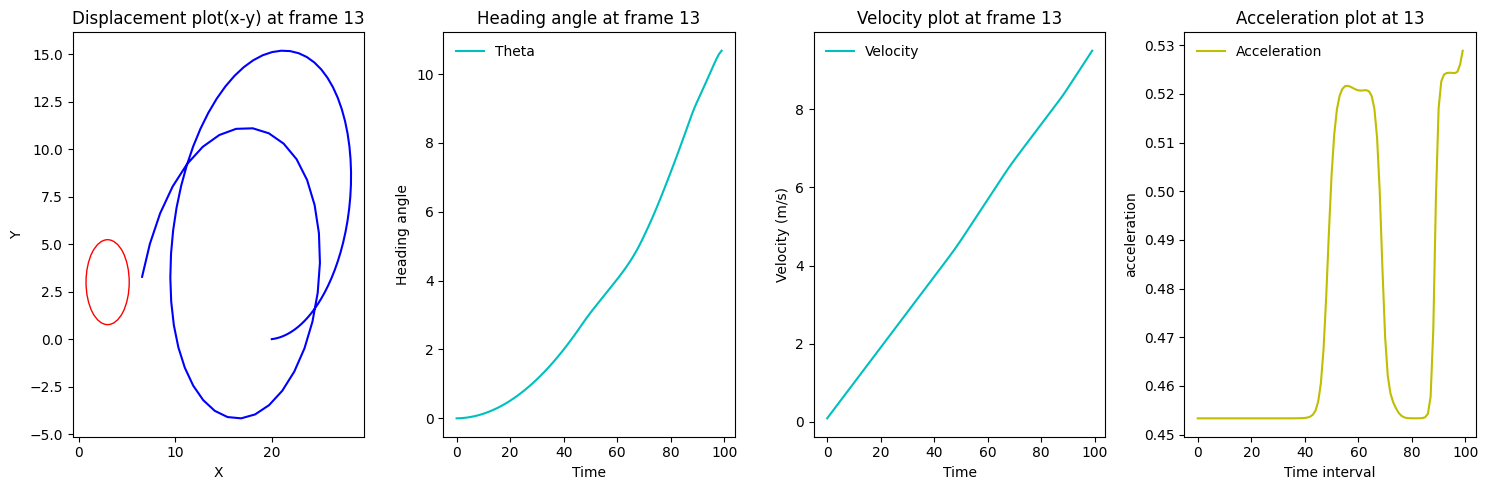

[15] loss: 73.241


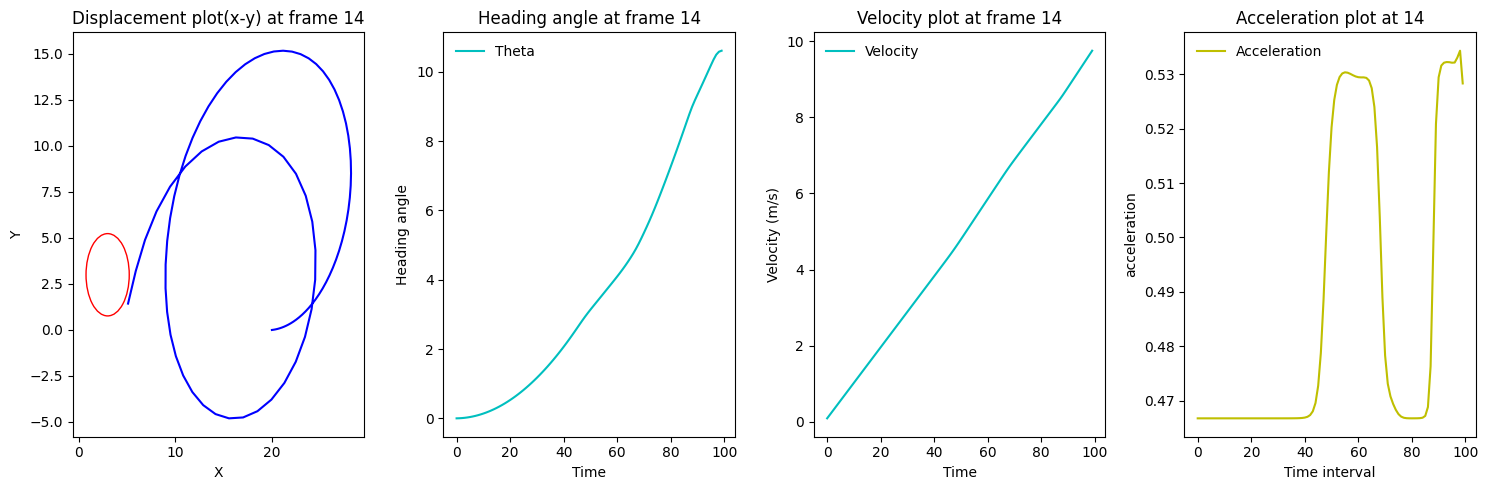

[16] loss: 79.380


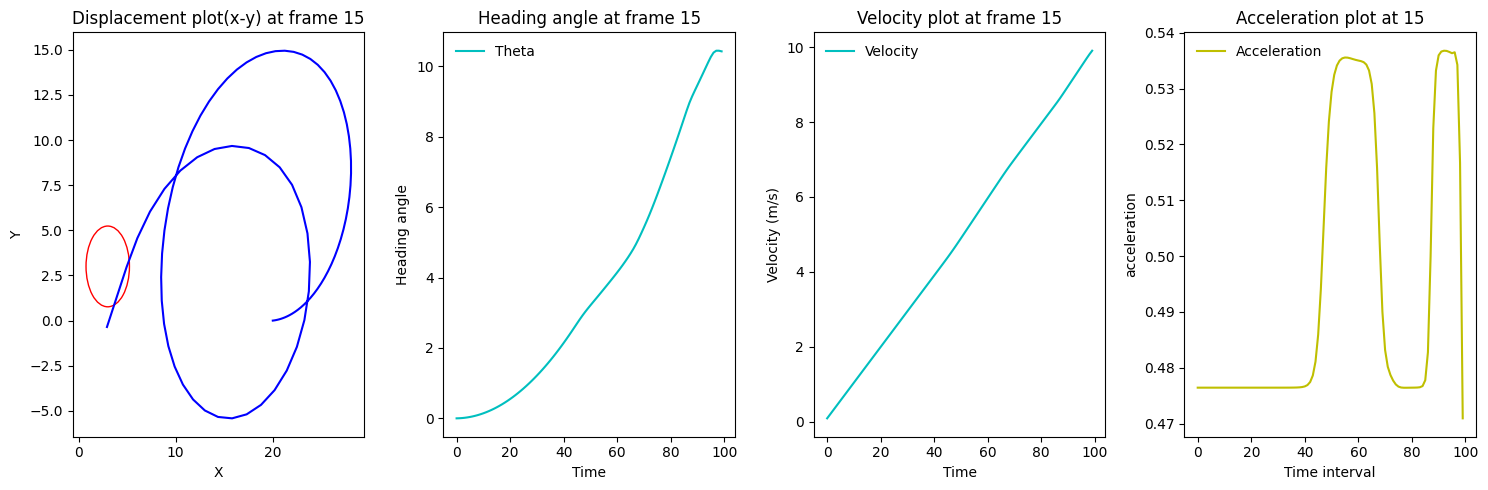

[17] loss: 100.388


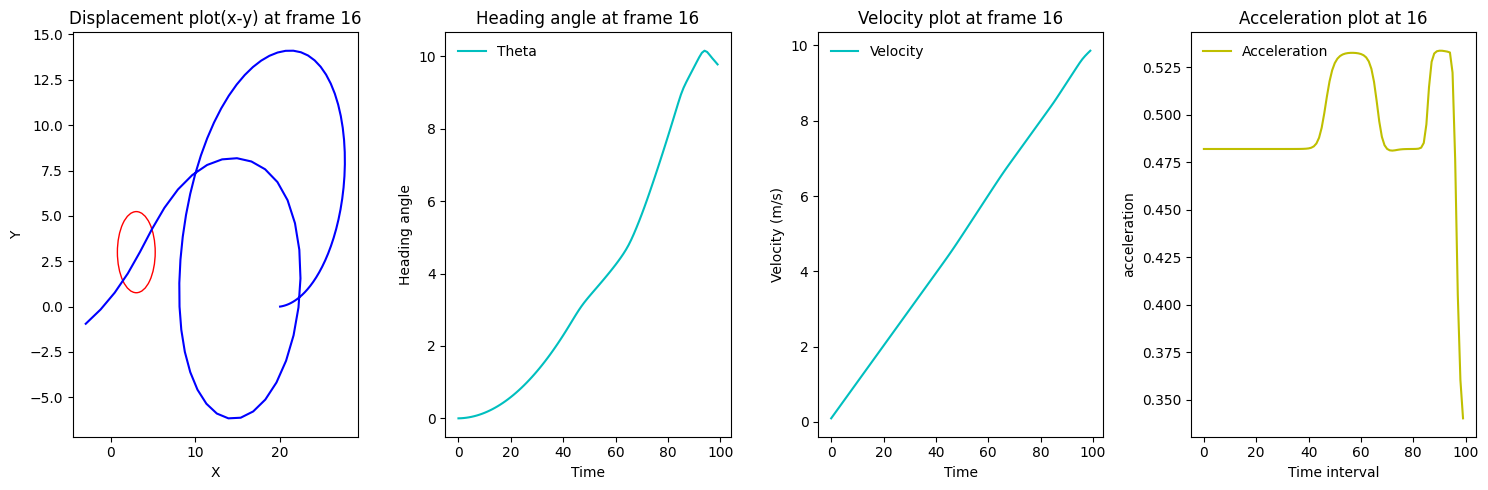

[18] loss: 91.402


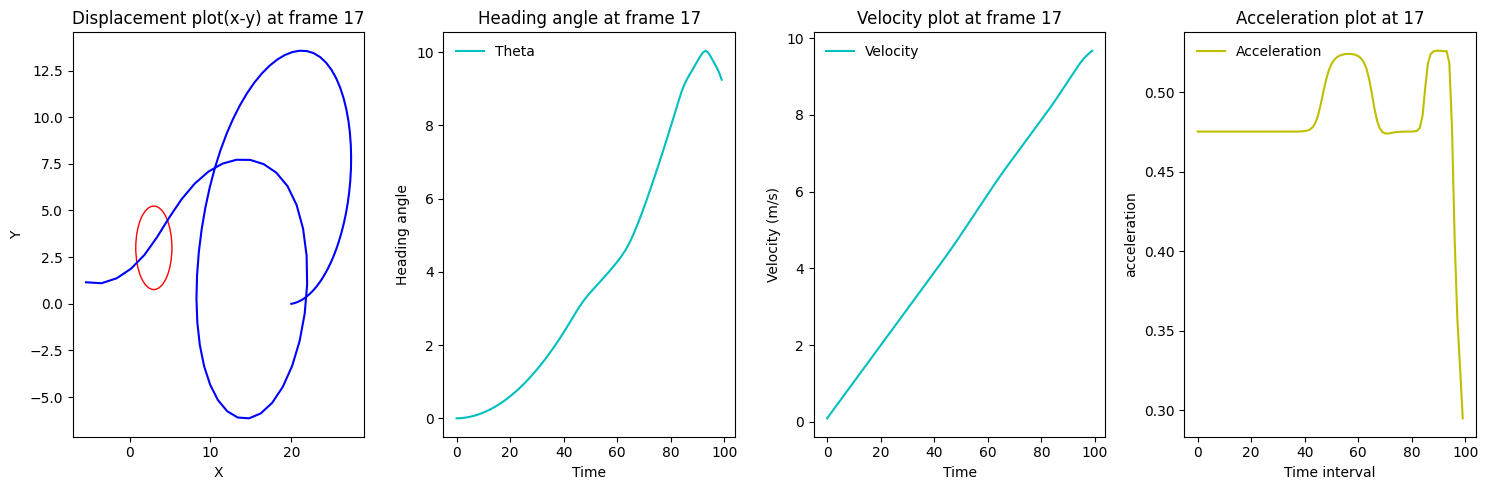

[19] loss: 88.195


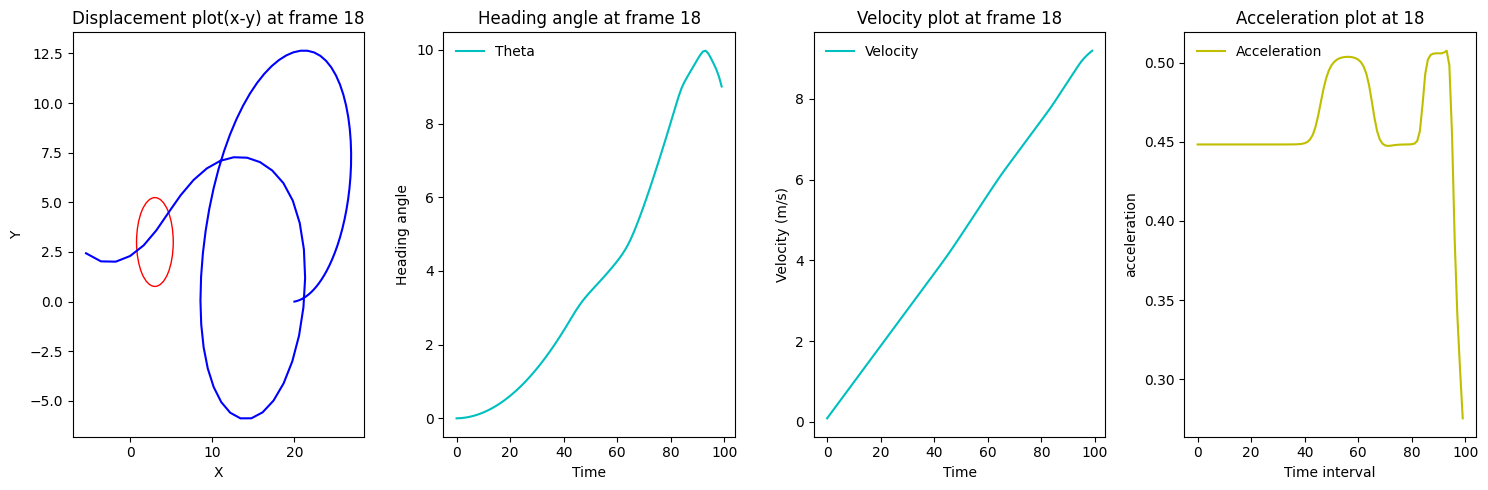

[20] loss: 86.270


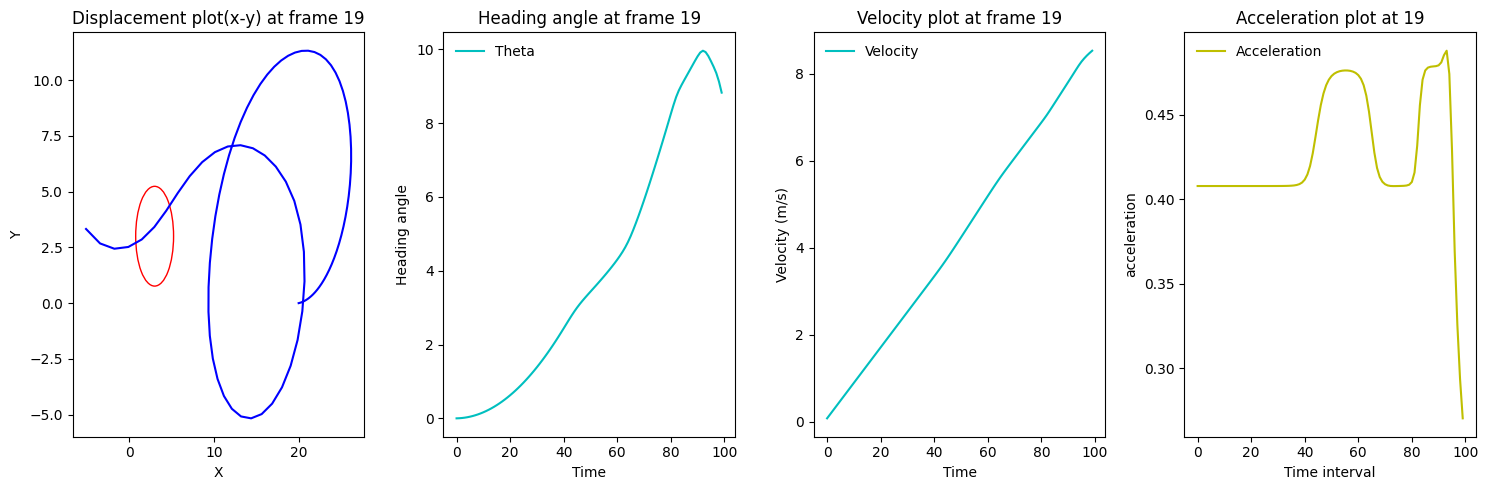

[21] loss: 28.869


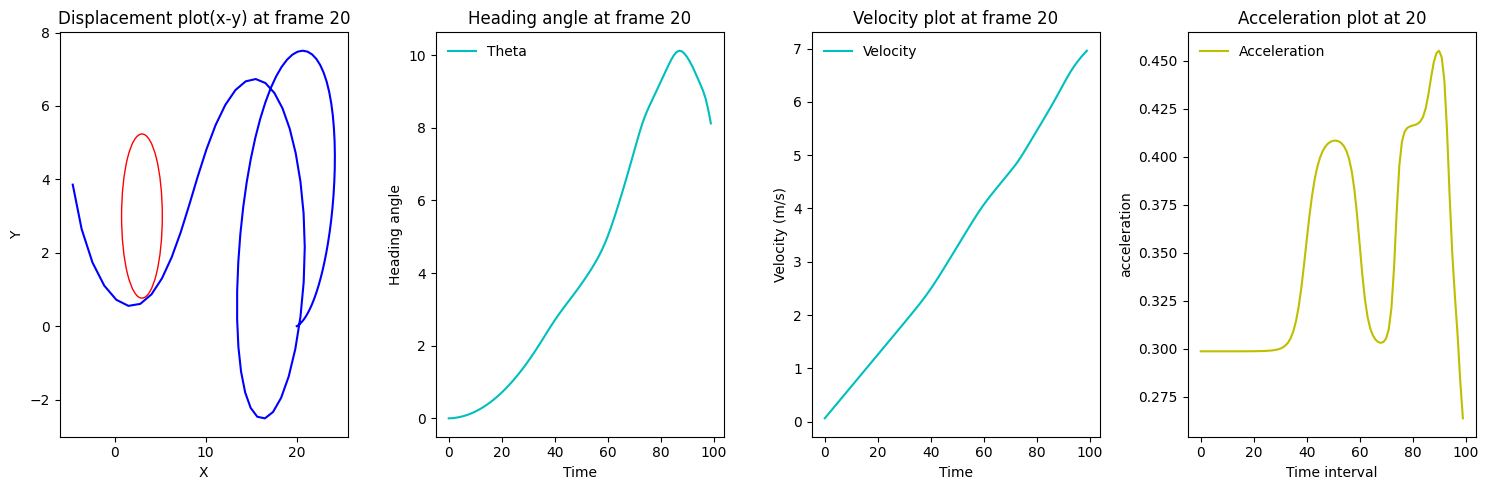

[22] loss: 23.938


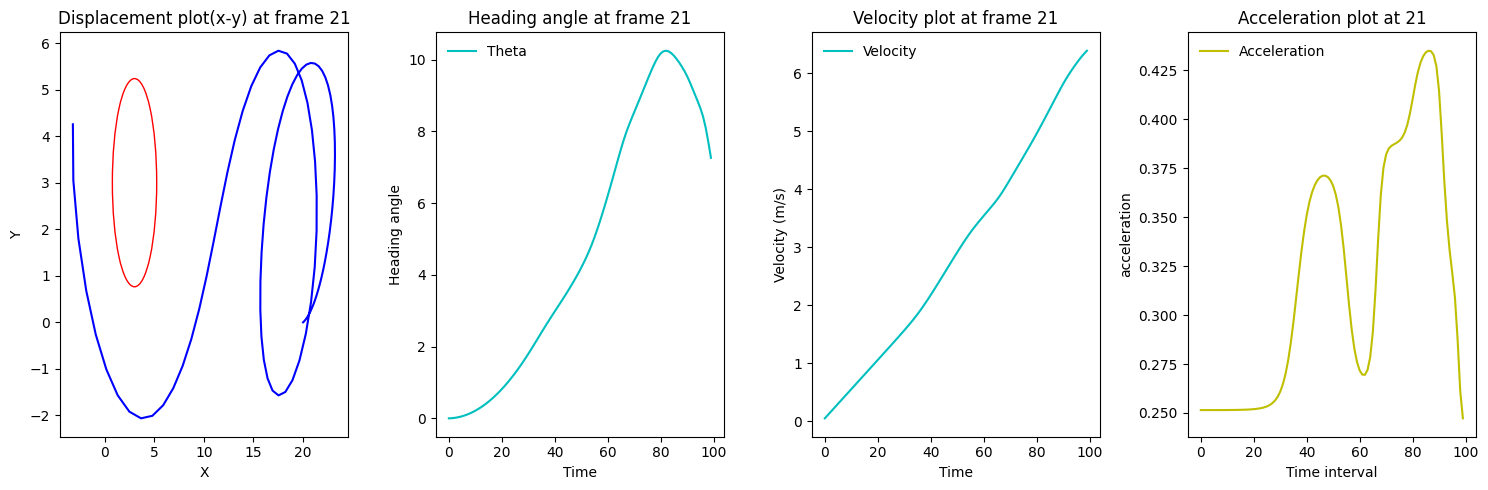

[23] loss: 20.951


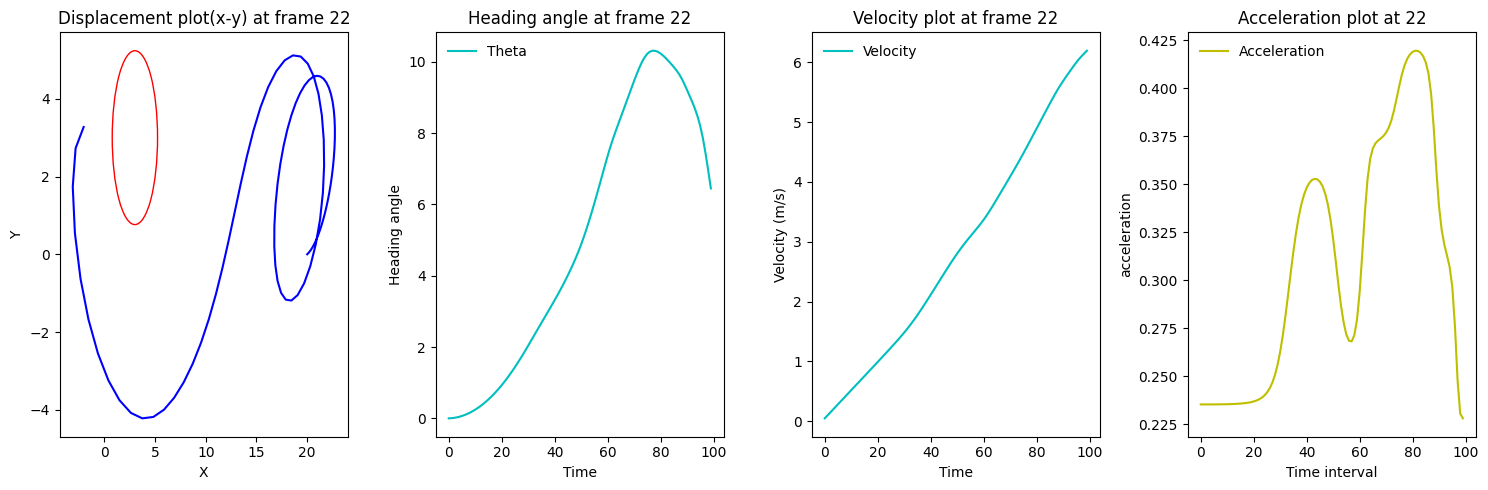

[24] loss: 19.941


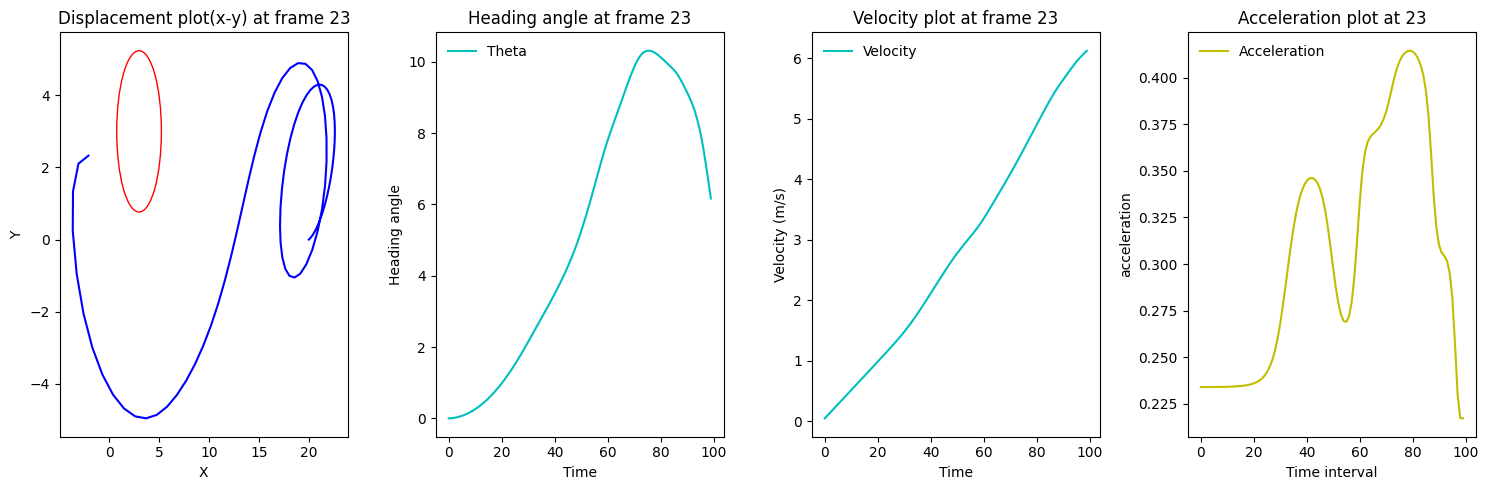

[25] loss: 19.411


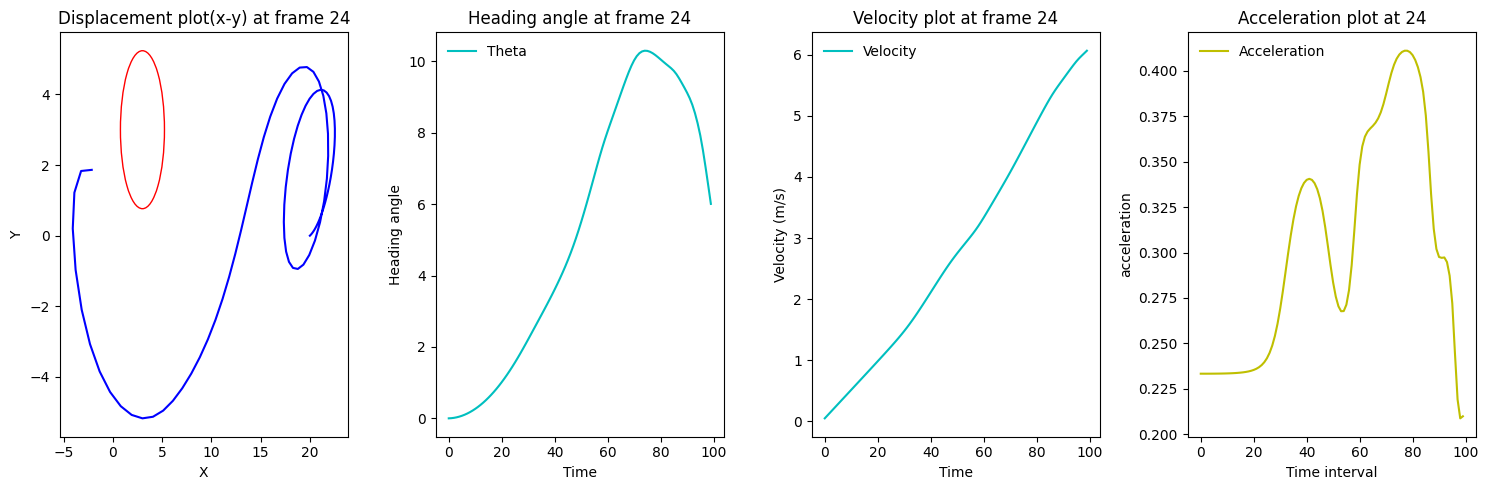

[26] loss: 18.855


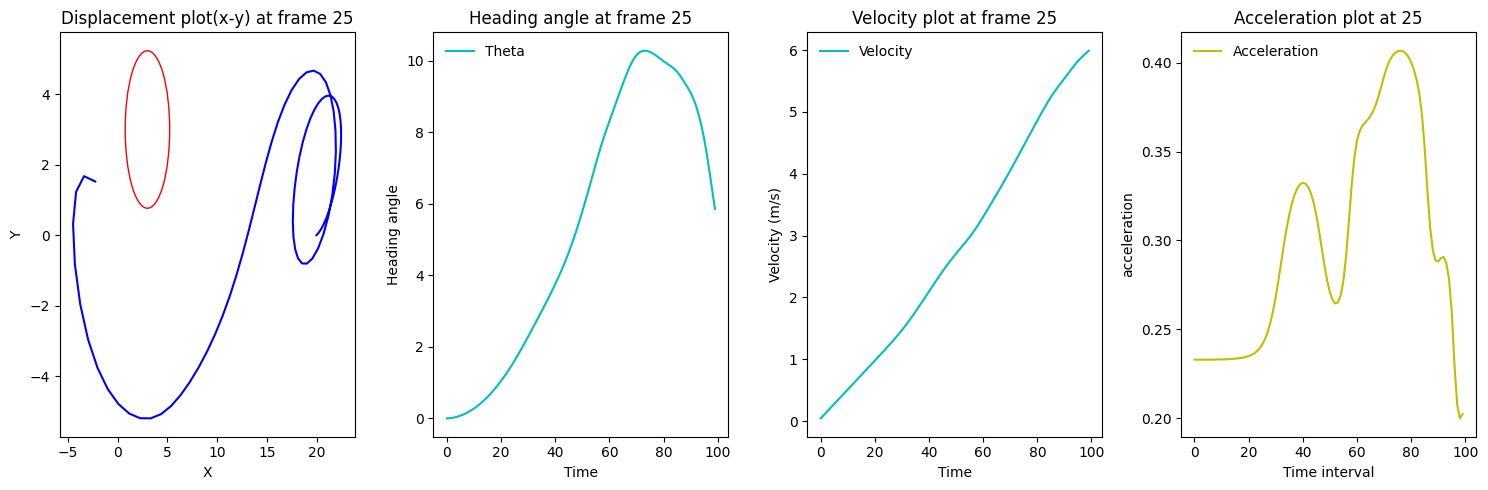

[27] loss: 18.088


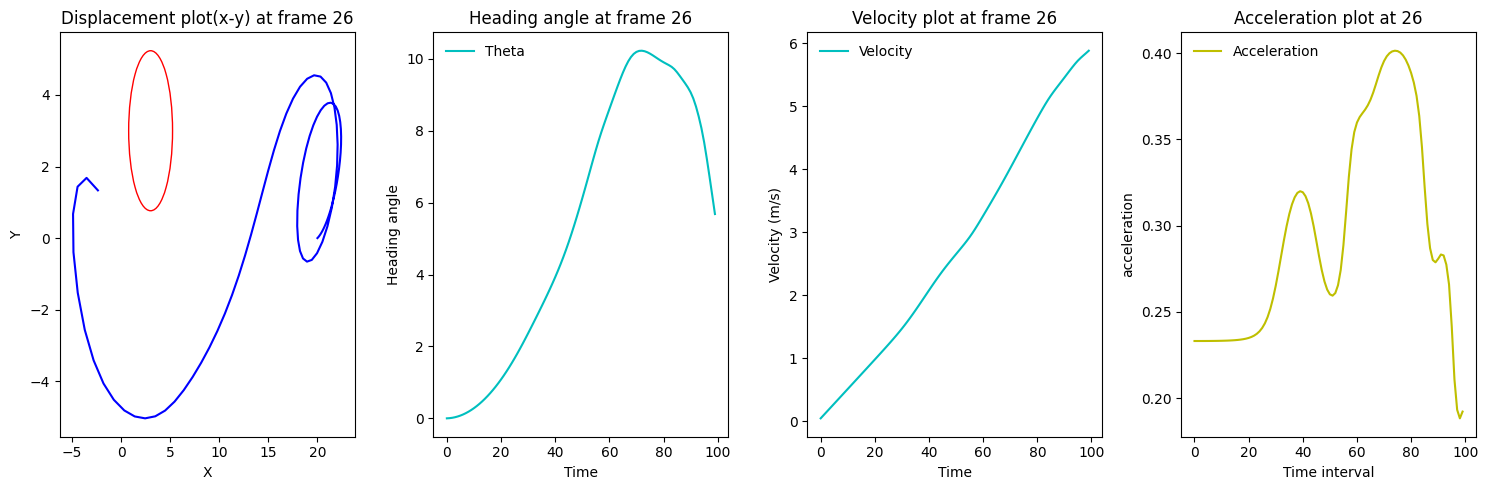

[28] loss: 16.660


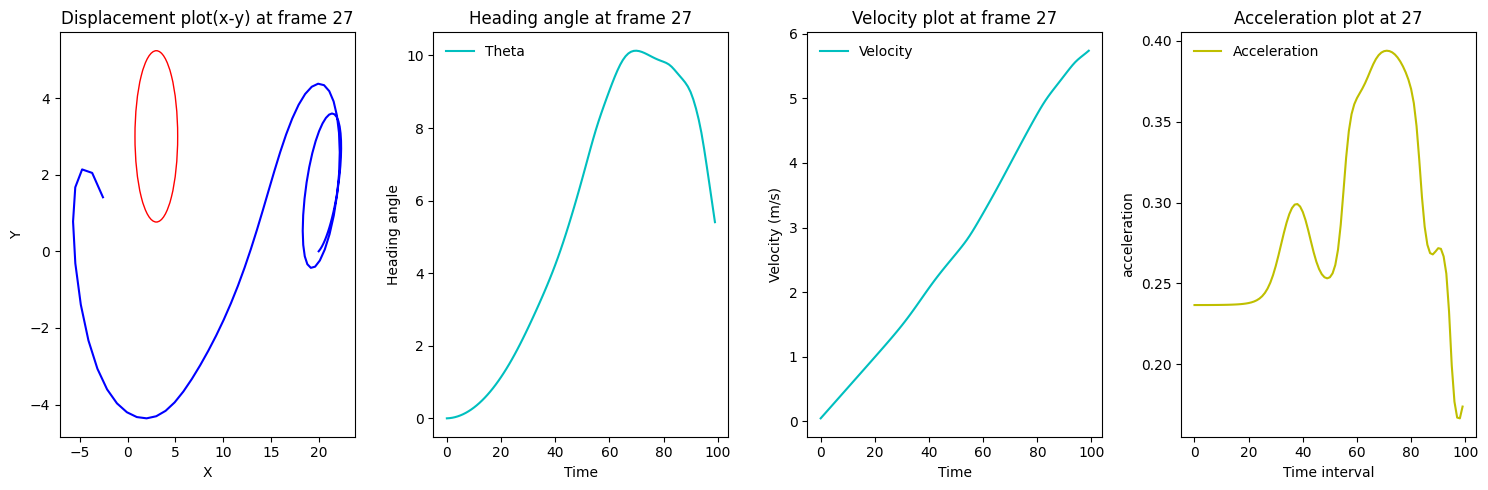

[29] loss: 14.874


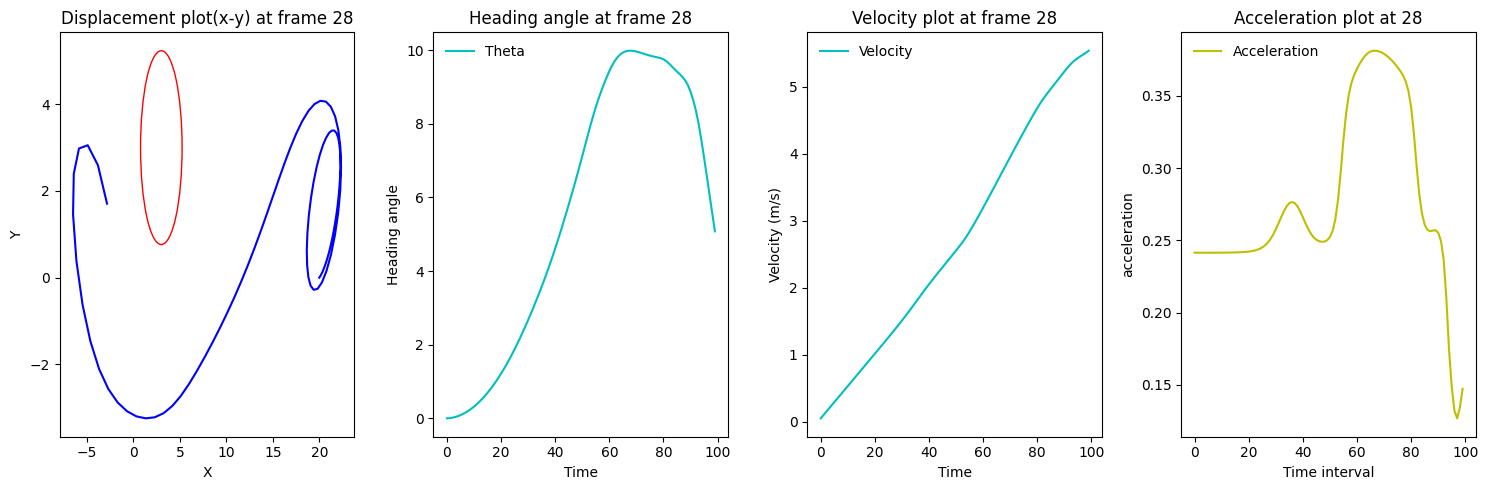

[30] loss: 13.491


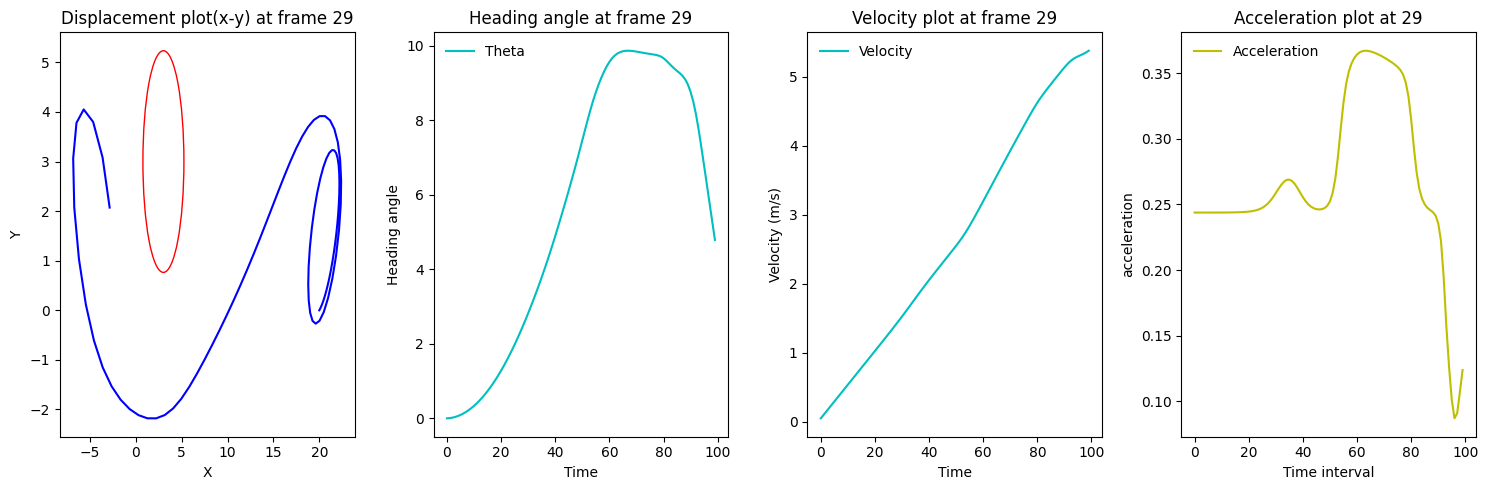

[31] loss: 12.406


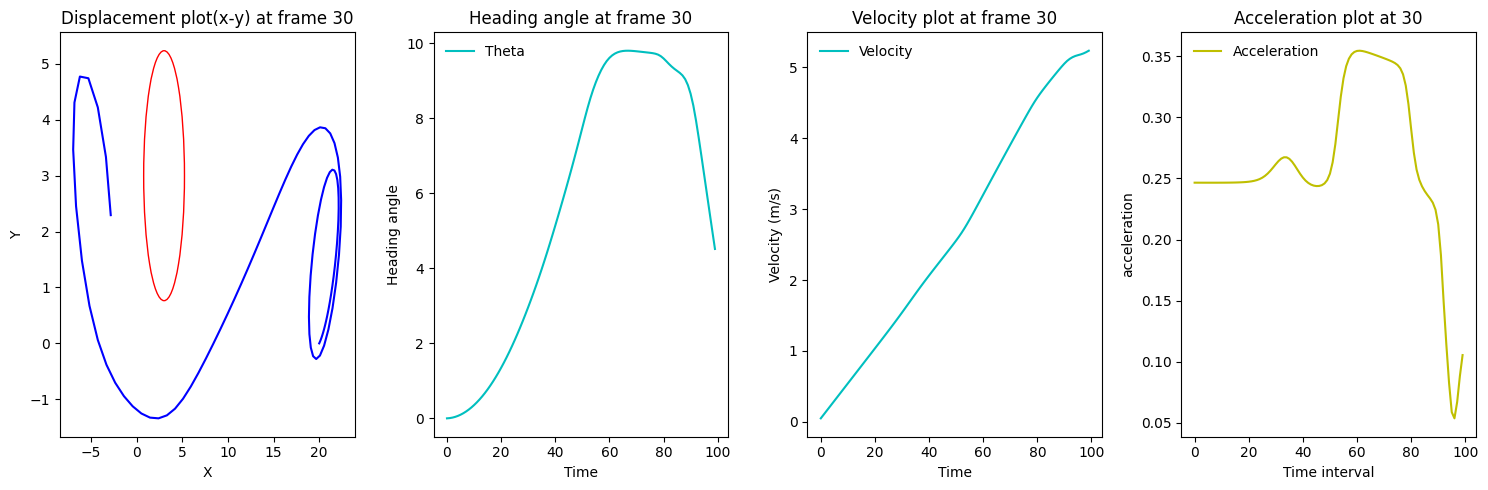

[32] loss: 11.316


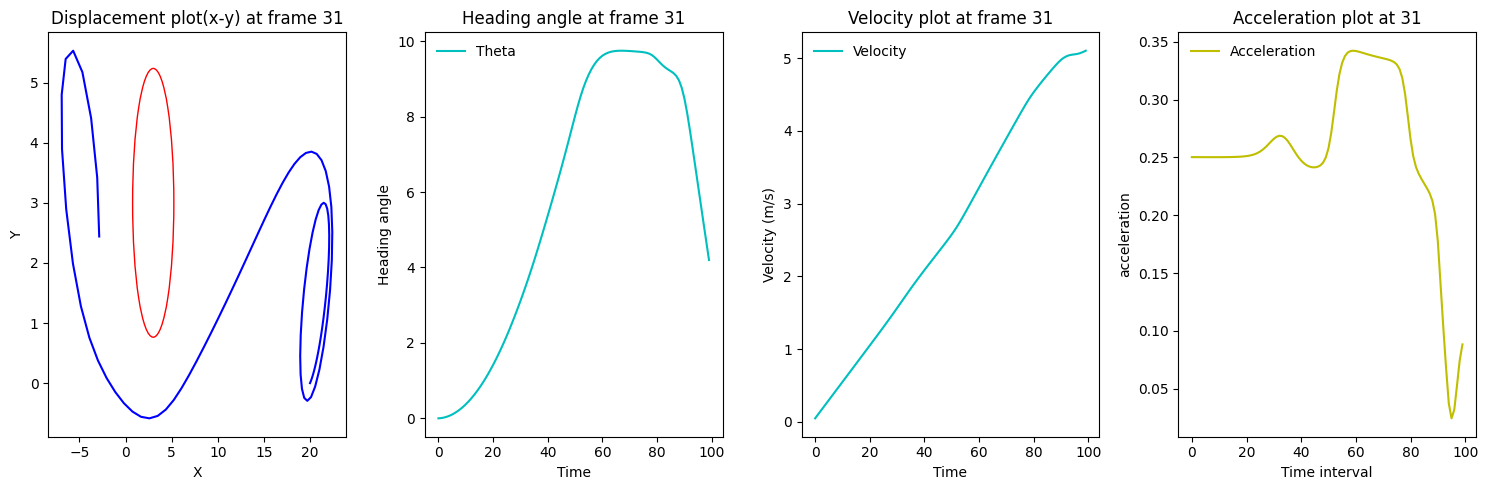

[33] loss: 10.027


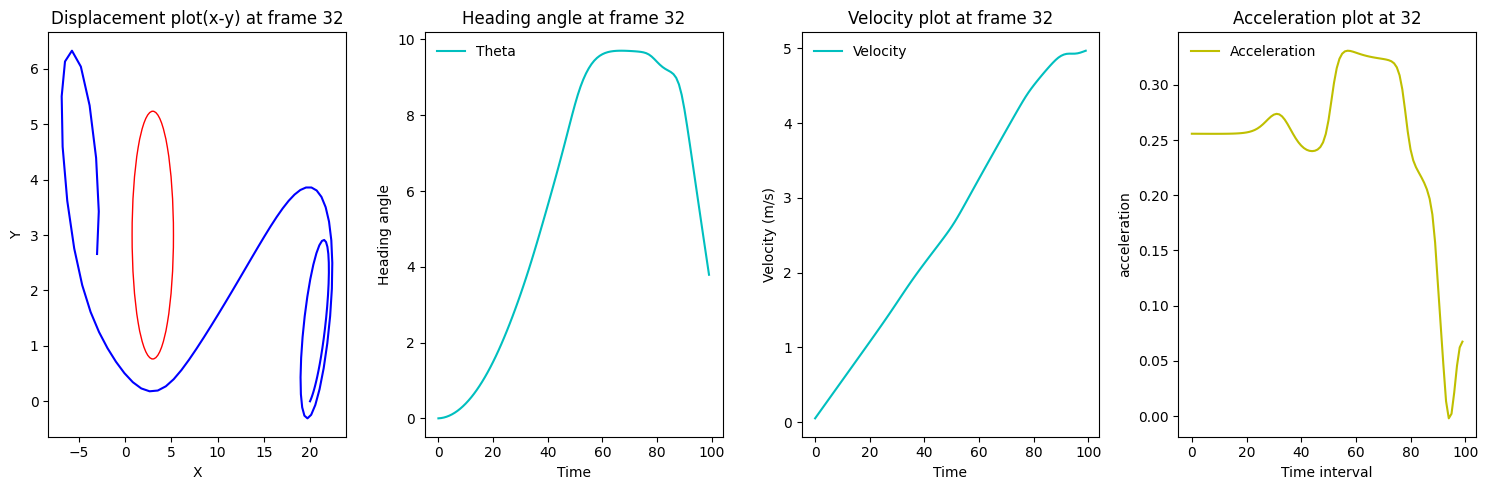

[34] loss: 17.046


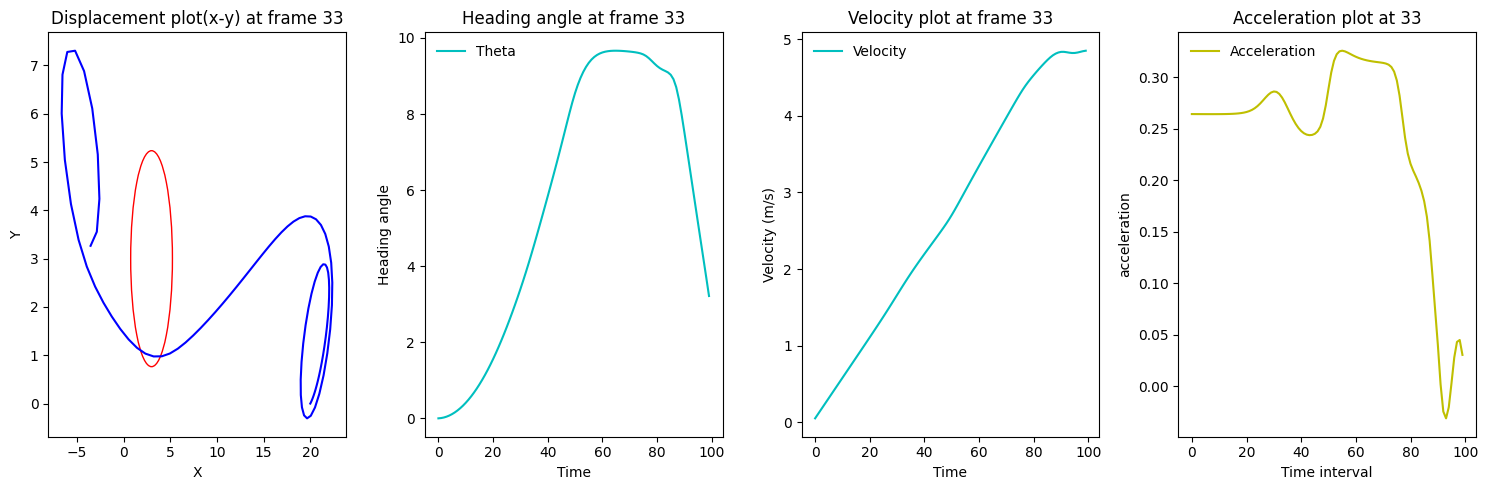

[35] loss: 25.615


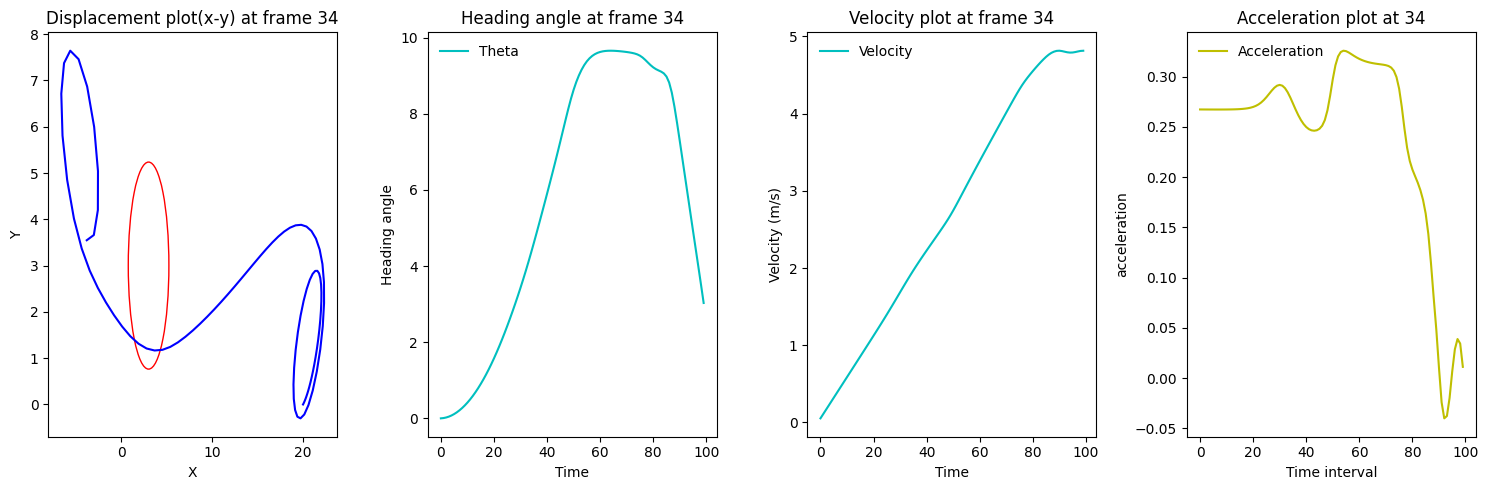

[36] loss: 27.976


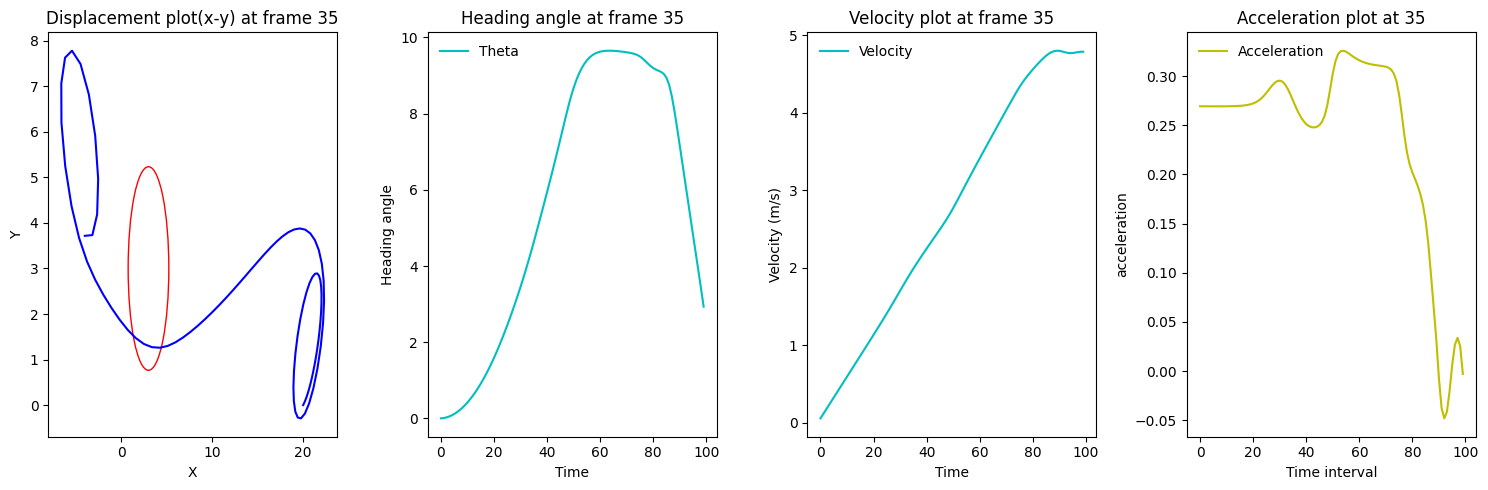

[37] loss: 30.079


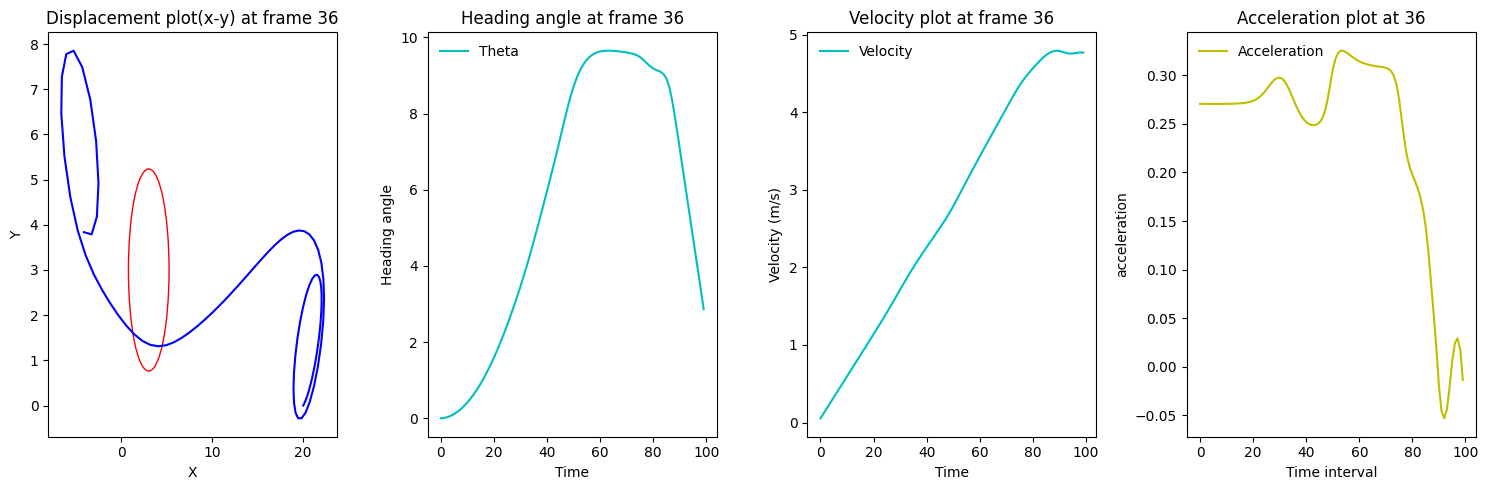

[38] loss: 31.607


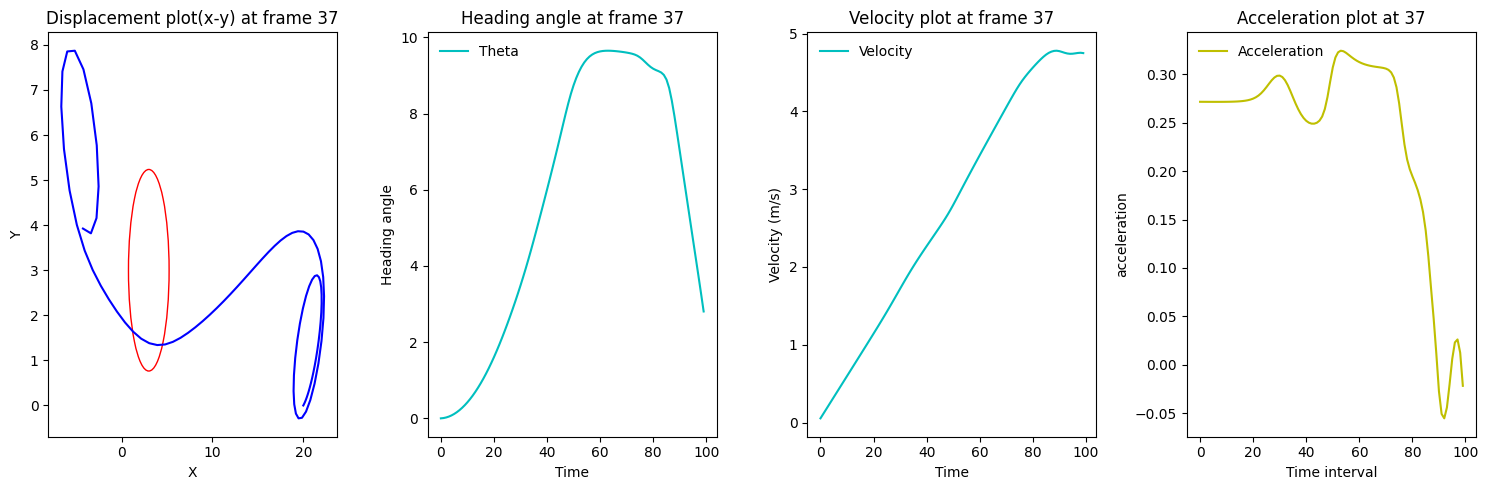

[39] loss: 31.089


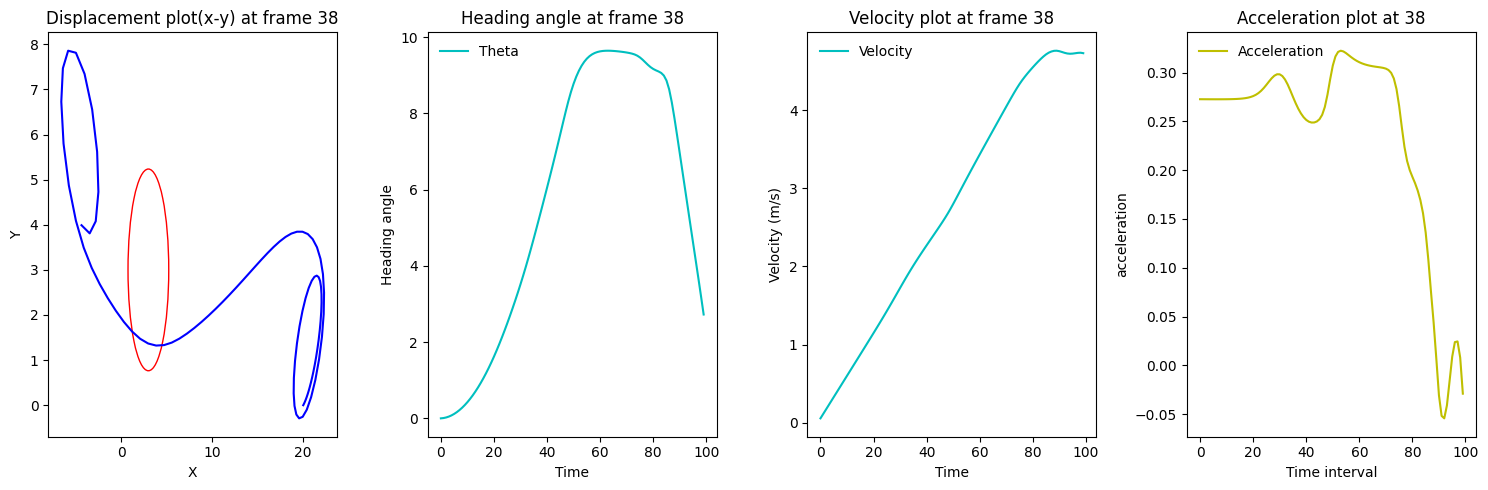

[40] loss: 27.453


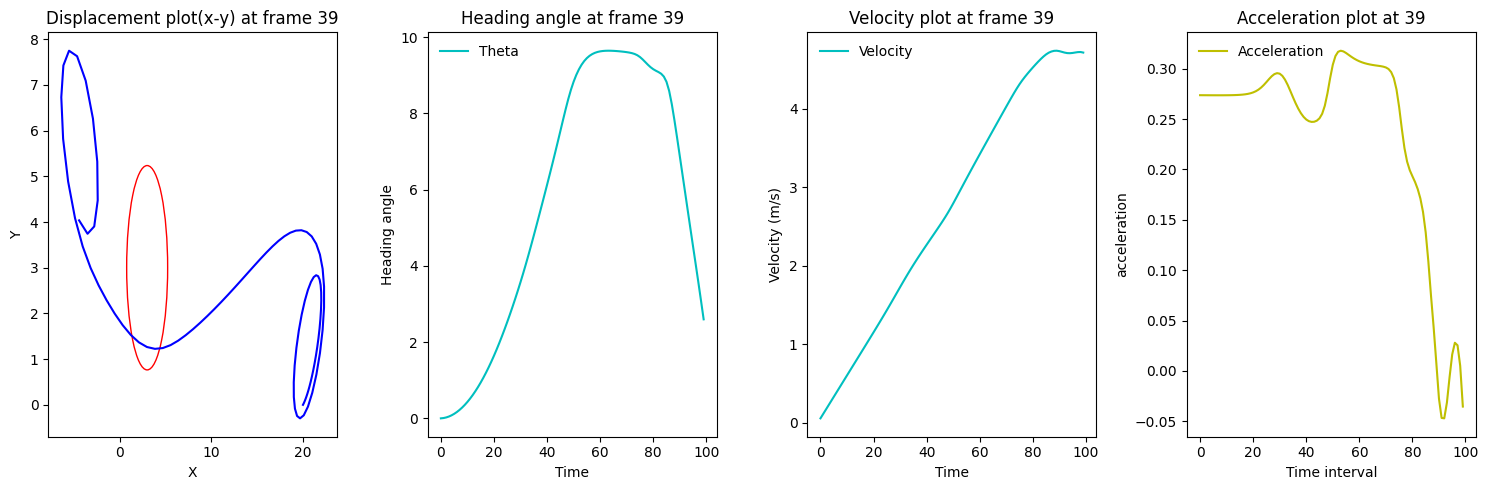

[41] loss: 16.182


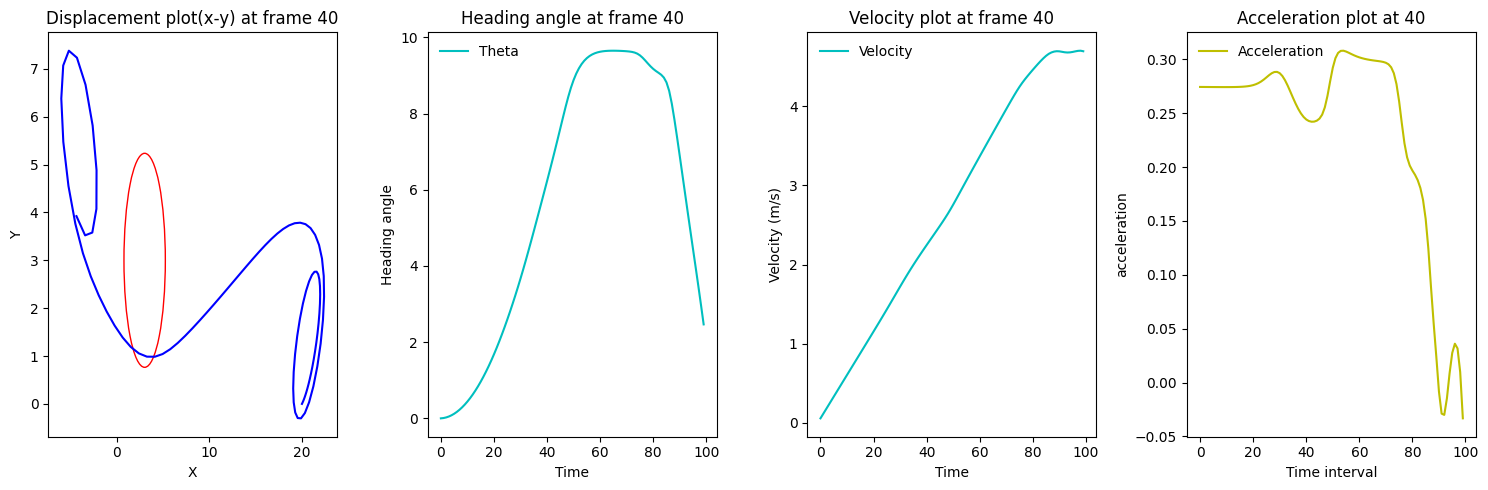

[42] loss: 6.709


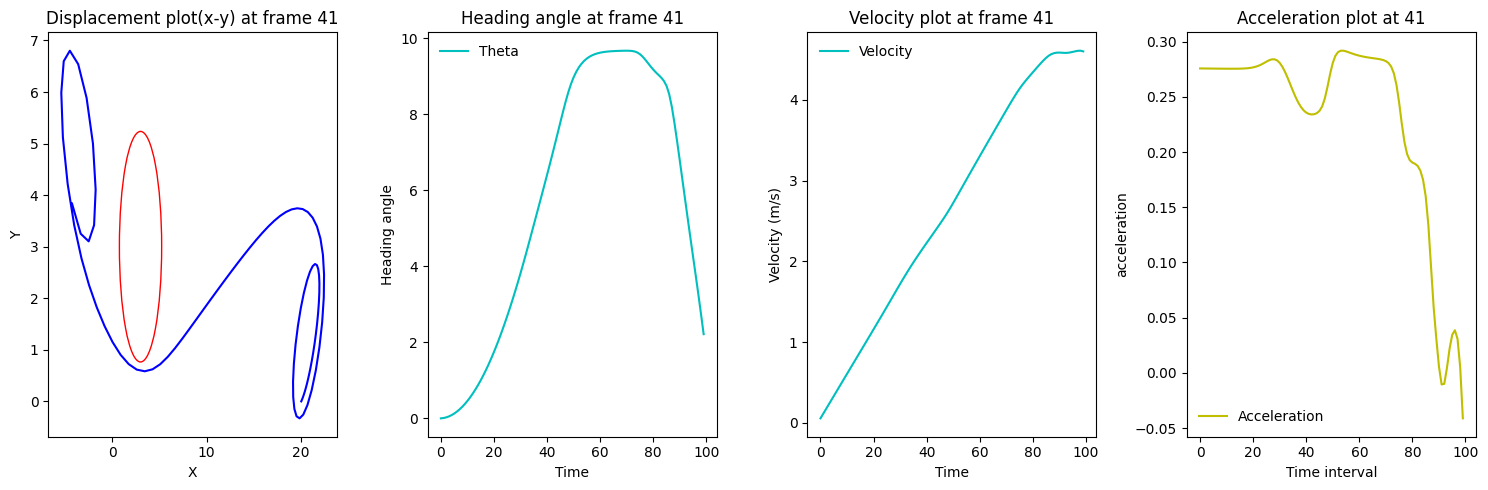

[43] loss: 5.605


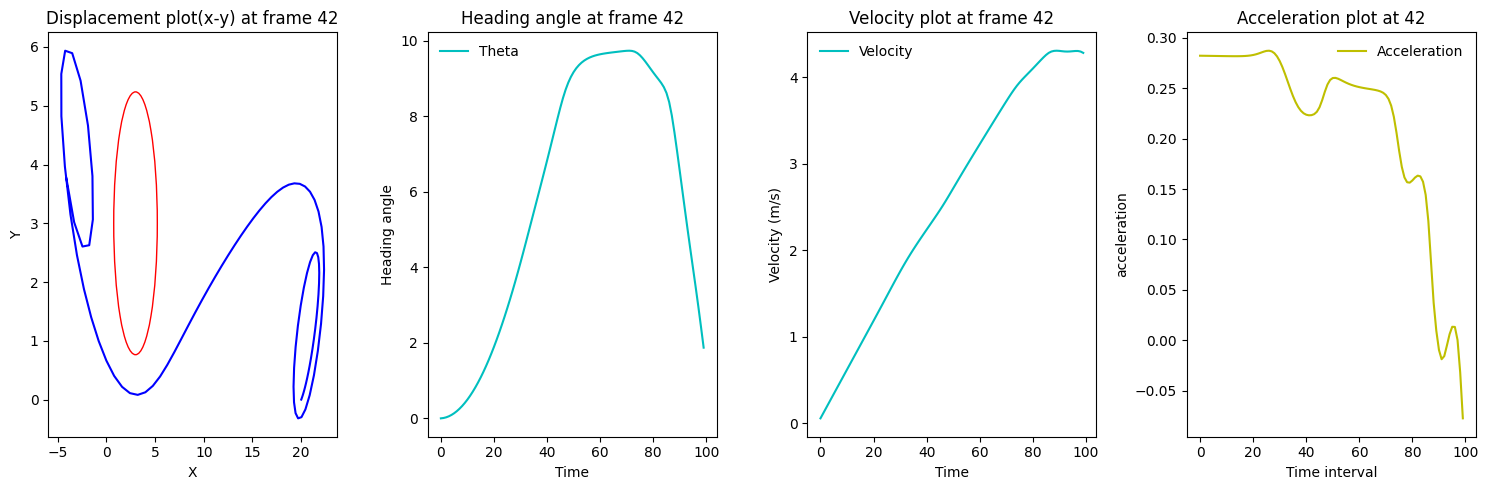

[44] loss: 4.749


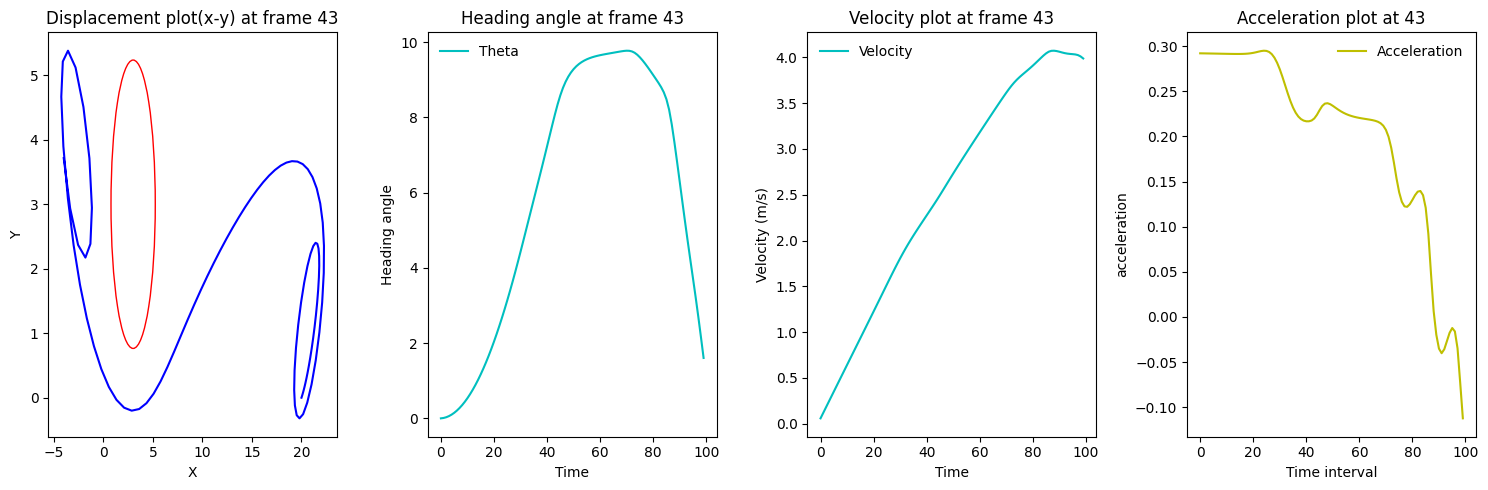

[45] loss: 3.933


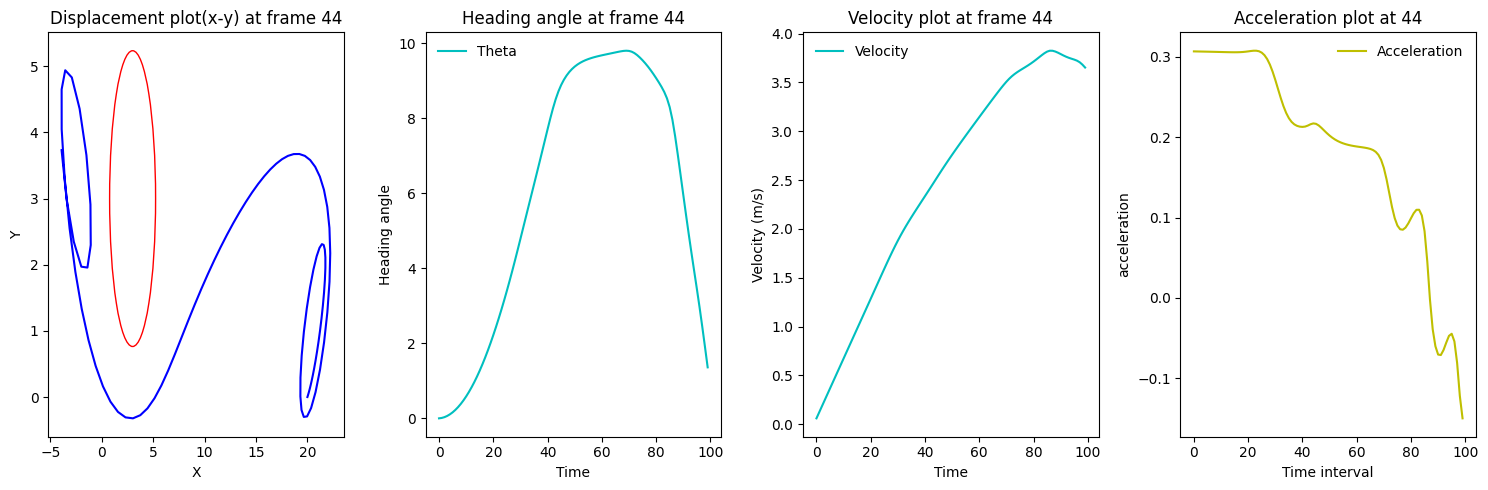

[46] loss: 3.335


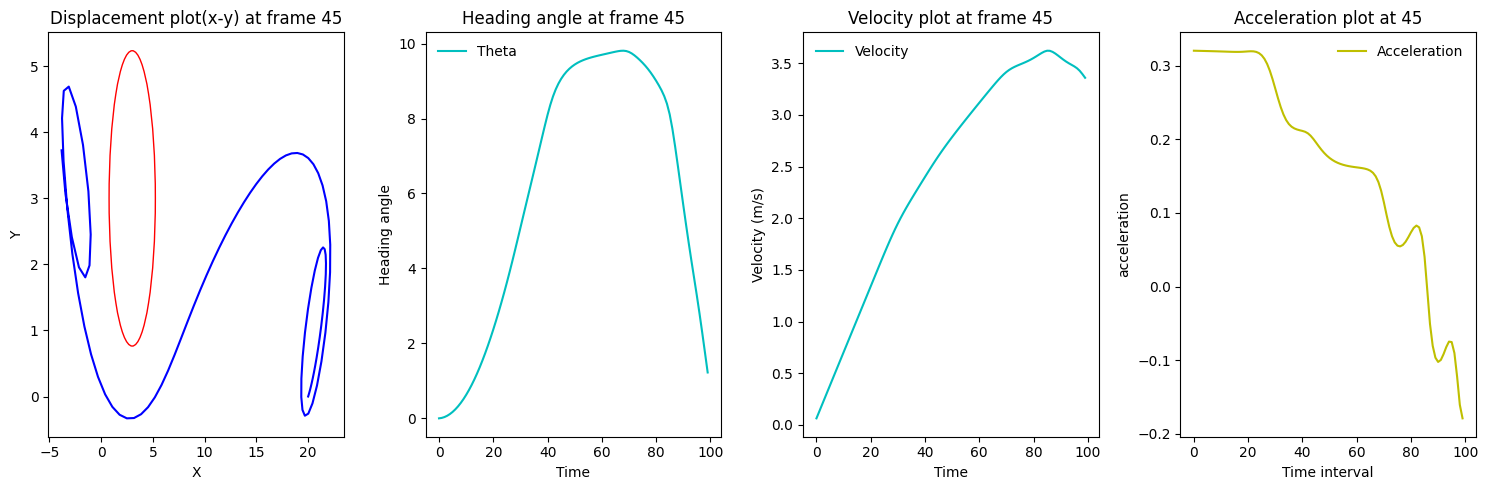

[47] loss: 2.878


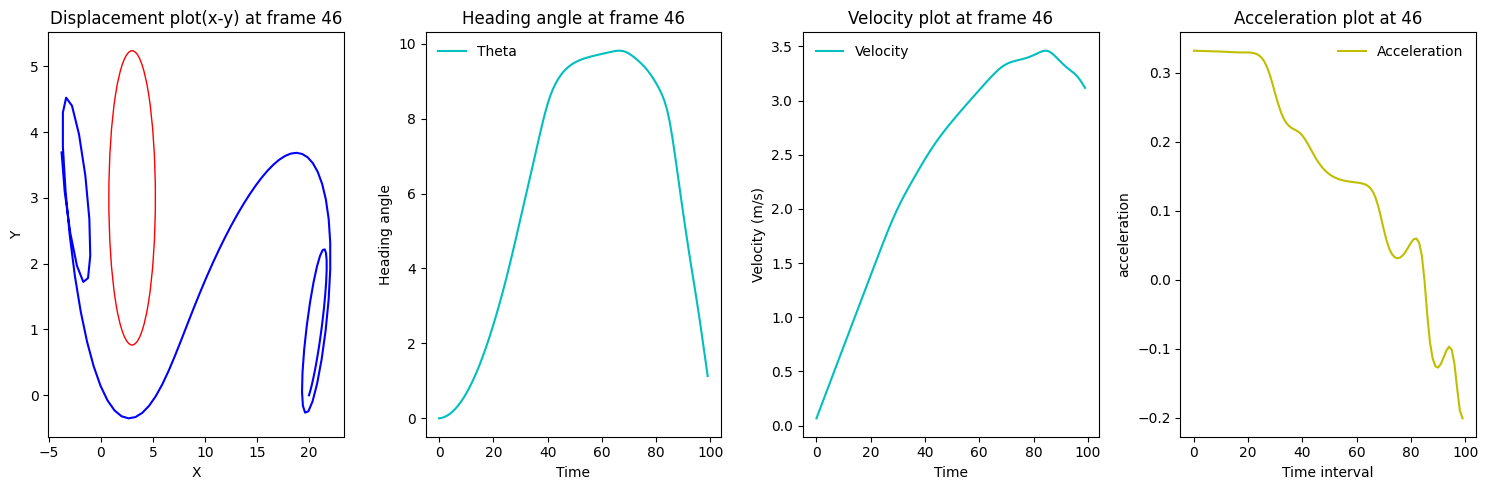

[48] loss: 2.491


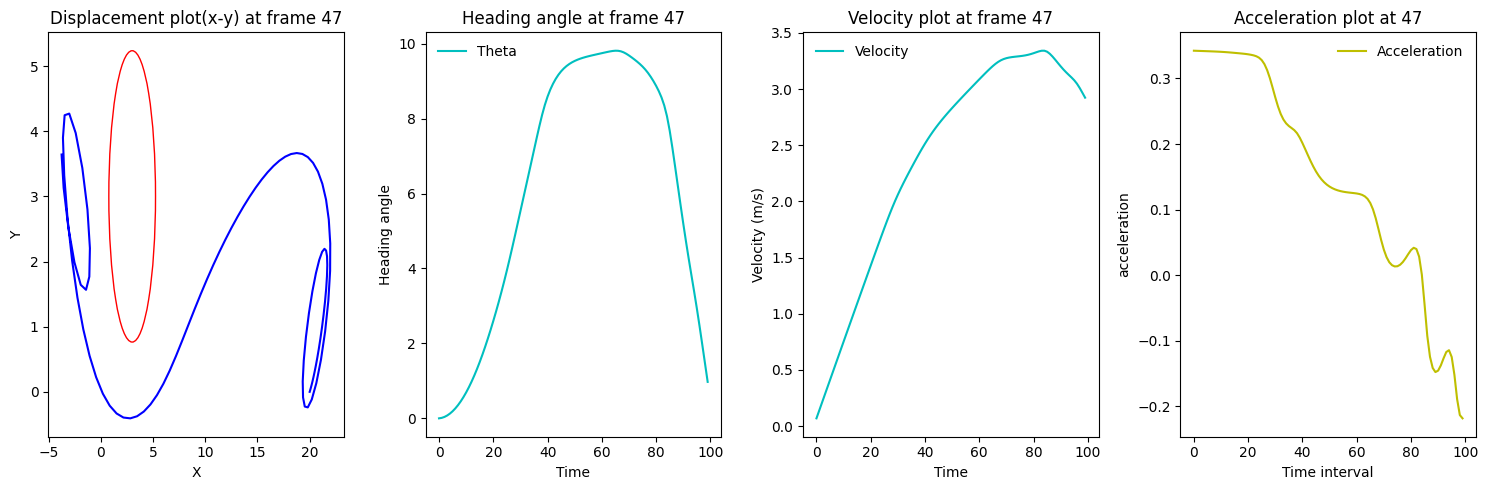

[49] loss: 2.099


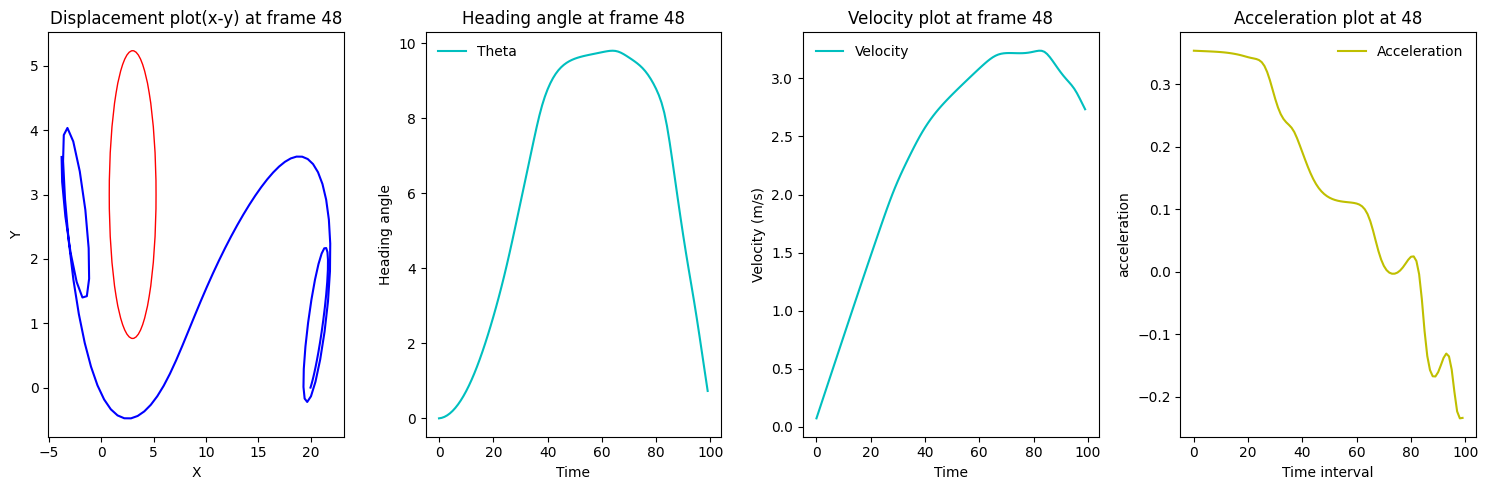

[50] loss: 1.756


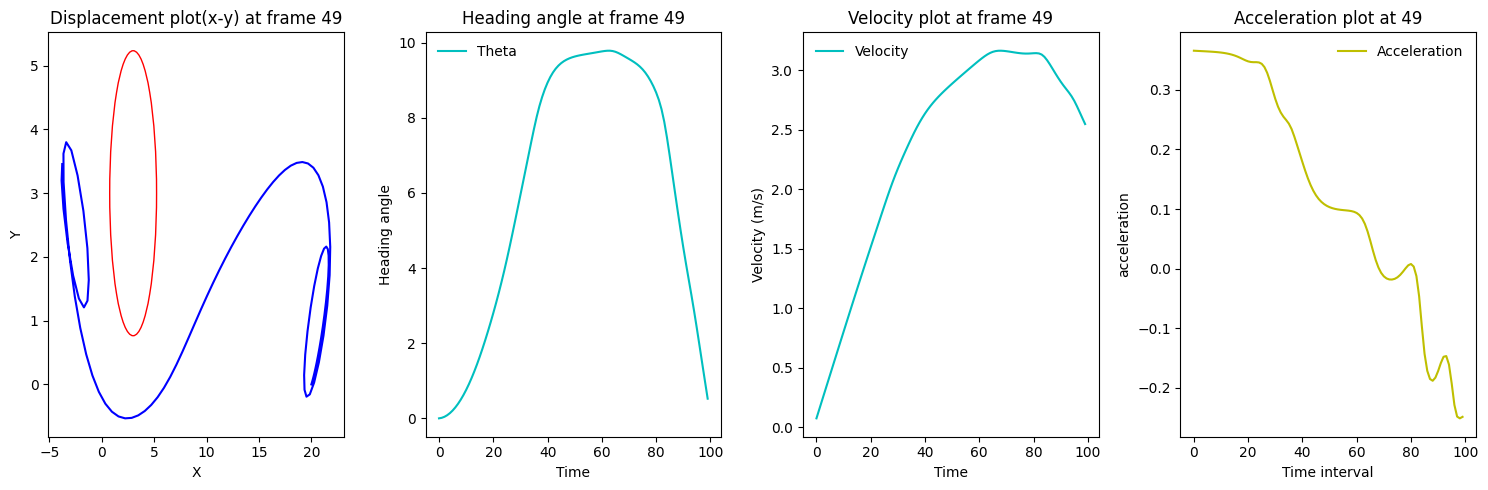

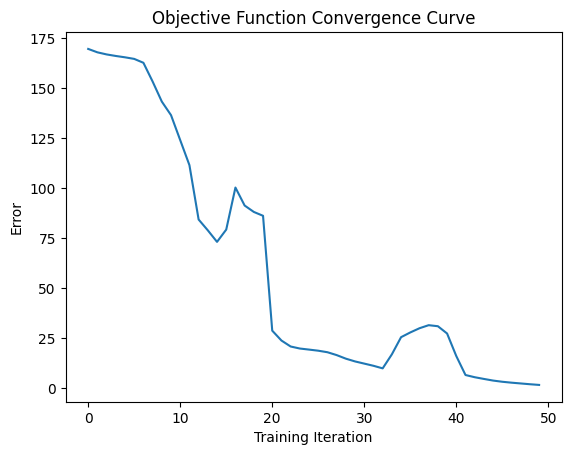

In [14]:
class Dynamics(nn.Module):

    def __init__(self):
        super(Dynamics,self).__init__()

    def forward(self,state,action):

        """
        action[0] = acceleration
        action[1] = steering angle

        state[0] = x
        state[1] = y
        state[2] = theta
        state[3] = velocity

        """
        a1=action[0,1]
        beta=torch.atan(0.5*torch.tan(a1))
        state_tensor = torch.zeros((1, 4))
        state_tensor[0, 0] = torch.cos(state[0, 2])
        state_tensor[0, 1] = torch.sin(state[0, 2])
        state_tensor[0, 2] = torch.tan(a1)

        state_theta = torch.zeros((1, 4))
        state_theta[0, 0] = torch.sin(state[0, 2])
        state_theta[0, 1] = torch.cos(state[0, 2])
        cos_beta=torch.cos(beta)
        cos_tensor = torch.mul(torch.tensor([1.,1.,1.,0.]),cos_beta.reshape(-1,1))
        sin_beta=torch.sin(beta)
        sin_tensor = torch.mul(torch.tensor([1.,1.,0.,0.]),sin_beta.reshape(-1,1))

        velocity_mat = torch.mul(torch.tensor([1.,1.,1.,0.]),state[0,3].reshape(-1,1))
        angle_tensor = torch.mul(cos_tensor,state_tensor) + torch.mul(sin_tensor,state_theta)
        inter_mat = torch.mul(velocity_mat,angle_tensor)
        accel_tensor =torch.mul(torch.tensor([0., 0., 0., 1.]),action[0, 0].reshape(-1, 1))
        final_state = frame_time*(inter_mat+accel_tensor)
        state = state + final_state

        return state

class Controller(nn.Module):
    def __init__(self,dim_input,dim_hidden,dim_output):
        """
        dim_input = No. of state (4)
        dim_output = No. of actions (2)
        dim_hidden = User choice

        """
        super(Controller,self).__init__()

        self.network = nn.Sequential(
            nn.Linear(dim_input,dim_hidden),
            nn.Tanh(),
            nn.Linear(dim_hidden,dim_hidden),
            nn.Tanh(),
            nn.Linear(dim_hidden,dim_output),
            nn.Sigmoid())

    def forward(self,state):
            action = self.network(state)
            action = (action - torch.tensor([0.5, 0.5]))*2
            #print (action)
            return action

class Simulation(nn.Module):
    def __init__(self,controller,dynamics,T):
        super(Simulation,self).__init__()
        self.state=self.initialize_state()
        self.controller=controller
        self.dynamics=dynamics
        self.T=T
        self.theta_trajectory=torch.empty((1,0))
        self.u_trajectory=torch.empty((1,0))

    def forward(self,state):
        self.action_trajectory=[]
        self.state_trajectory=[]
        k=torch.tensor(0)
        for i in range (self.T):
            action = self.controller(state)
            state=self.dynamics(state,action)
            self.action_trajectory.append(action)
            self.state_trajectory.append(state)
        return self.error(state)

    @staticmethod
    def initialize_state():
        state=[[20.,0.,0.,0.]]

        return torch.tensor(state,requires_grad=False).float()

    def error(self,state):
      x1=torch.tensor([tensor[:,0] for tensor in self.state_trajectory])
      y1=torch.tensor([tensor[:,1] for tensor in self.state_trajectory])
      return torch.mean((state-torch.tensor([[-4.,3.,0.,0.]]))**2) + torch.tensor(10)*(abs(min(0,torch.min((x1-3)**2+(y1-3)**2 - 5))))

class Optimize:

    def __init__(self,simulation):
        self.simulation=simulation
        self.parameters=simulation.controller.parameters()
        self.optimizer = optim.LBFGS(self.parameters,lr=0.01)
        self.loss_list=[]

    def step(self):
        def closure():
            loss = self.simulation(self.simulation.state)
            self.optimizer.zero_grad()
            loss.backward()
            return loss

        self.optimizer.step(closure)
        return closure()

    def train(self,epochs):
        l=np.zeros(epochs)
        for epoch in range(epochs):
            self.epoch = epoch
            loss=self.step()
            self.loss_list.append(loss)
            print('[%d] loss: %.3f' % (epoch + 1, loss))
            l[epoch]=loss
            self.visualize()


        plt.plot(list(range(epochs)), l)
        plt.title('Objective Function Convergence Curve')
        plt.xlabel('Training Iteration')
        plt.ylabel('Error')
        plt.show()

    def visualize(self):
        data = np.array([self.simulation.state_trajectory[i][0].detach().numpy() for i in range(self.simulation.T)])
        x = data[:, 0]
        y = data[:, 1]
        theta = data[:, 2]
        v = data[:, 3]
        action_data = np.array([self.simulation.action_trajectory[i][0].detach().numpy() for i in range(self.simulation.T)])
        acc = action_data[:,0]
        ster_ang=action_data[:,1]
        frame = range(self.simulation.T)

        fig, ax = plt.subplots(1,4, tight_layout = 1,figsize = (15,5))

        ax[0].plot(x, y, c = 'b')
        ax[0].set_xlabel("X")
        ax[0].set_ylabel("Y")
        ax[0].set(title=f'Displacement plot(x-y) at frame {self.epoch}')
        circle = patches.Circle((3, 3), radius=2.236, edgecolor='r', facecolor='none')
        ax[0].add_patch(circle)


        ax[1].plot(frame, theta, c = 'c', label = "Theta")
        ax[1].set_xlabel("Time")
        ax[1].set_ylabel("Heading angle")
        ax[1].legend(frameon=0)
        ax[1].set(title =f'Heading angle at frame {self.epoch}')

        ax[2].plot(frame, v, c = 'c', label = "Velocity")
        ax[2].set_xlabel("Time")
        ax[2].set_ylabel("Velocity (m/s)")
        ax[2].legend(frameon=0)
        ax[2].set(title =f'Velocity plot at frame {self.epoch}')

        ax[3].plot(frame, acc, c = 'y', label = "Acceleration")
        ax[3].set_xlabel("Time interval")
        ax[3].set_ylabel("acceleration")
        ax[3].legend(frameon=0)
        ax[3].set(title=f'Acceleration plot at {self.epoch}')
        plt.show()

T = 100  # number of time steps of the simulation
dim_input = 4  # state space dimensions
dim_hidden = 8  # latent dimensions
dim_output = 2  # action space dimensions
d = Dynamics()
c = Controller(dim_input, dim_hidden, dim_output)
s = Simulation(c, d, T)
o = Optimize(s)
o.train(50)

Program end